In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('data.tsv', sep='\t', names=['timestamp', 'transport_id', 'transport_type', 'route_id', 'lat', 'lon'],
                parse_dates=[0], dtype={'transport_id': 'category', 'type': 'category', 'route_id': 'category'})
target_stops = pd.read_csv('debug.tsv', sep='\t', names=['transport_type', 'route_id', 'lat', 'lon'],
                           dtype={'id': 'category', 'type': 'category', 'route_id': 'category'})

In [3]:
df.head()

,timestamp,transport_id,transport_type,route_id,lat,lon
0,2015-05-12 14:24:33,3982,tramway,1,50.700576,51.212909
1,2015-05-12 14:25:13,3982,tramway,1,50.702068,51.212772
2,2015-05-12 14:25:53,3982,tramway,1,50.702930,51.212703
3,2015-05-12 14:26:33,3982,tramway,1,50.705974,51.212421
4,2015-05-12 14:27:13,3982,tramway,1,50.706775,51.212428


In [4]:
t = df[df['transport_id'] == '3982'].sort_values('timestamp')

In [5]:
time_deltas = t['timestamp'] - t['timestamp'].shift()

In [6]:
time_deltas.describe()

count                       563
mean     0 days 00:01:33.772646
std      0 days 00:03:58.584463
min             0 days 00:00:20
25%             0 days 00:00:40
50%             0 days 00:01:00
75%             0 days 00:01:40
max             0 days 01:27:43
Name: timestamp, dtype: object

In [7]:
split_delta = time_deltas.quantile(0.95)
print('95% timedelta quantile:', split_delta)
route_reset_steps = [0]
for i, delta in enumerate(time_deltas):
    if delta > split_delta:
        print(i)
        route_reset_steps.append(i)

95% timedelta quantile: 0 days 00:03:00
9
48
73
90
93
138
159
230
257
287
288
296
302
334
352
353
354
373
395
417
469
471
482
491
504
524
536
563


In [8]:
df.describe()

,lat,lon
count,1.064095e+06,1.064095e+06
mean,5.060662e+01,5.110628e+01
std,8.465822e-02,1.437978e-01
min,5.029642e+01,5.014520e+01
25%,5.054471e+01,5.105372e+01
50%,5.061157e+01,5.112848e+01
75%,5.067606e+01,5.118990e+01
max,5.104615e+01,5.205867e+01


In [9]:
# route_id = '11'
# transport_id = '7299'
# transport_type = 'tramway'

# route_id = '86'
# transport_id = '7090'
# transport_type = 'bus'

route_id = '71'
transport_id = '2991'
transport_type = 'trolleybus'

In [10]:
debug_route = df[  (df['transport_type'] == transport_type) 
               & (df['route_id'] == route_id)
               & (df['transport_id'] == transport_id)]

In [11]:
debug_route = debug_route.sort_values('timestamp')

In [12]:
debug_route.head()

,timestamp,transport_id,transport_type,route_id,lat,lon
503762,2015-05-12 18:24:41,2991,trolleybus,71,50.556419,51.059322
503763,2015-05-12 18:26:01,2991,trolleybus,71,50.556656,51.057040
503764,2015-05-12 18:28:42,2991,trolleybus,71,50.559059,51.046548
503765,2015-05-12 18:30:02,2991,trolleybus,71,50.560135,51.042094
503766,2015-05-12 18:32:41,2991,trolleybus,71,50.558399,51.039382


In [13]:
time_deltas = debug_route['timestamp'] - debug_route['timestamp'].shift()

In [14]:
time_deltas.describe()

count                       110
mean     0 days 00:01:49.700000
std      0 days 00:01:19.804411
min             0 days 00:01:19
25%             0 days 00:01:20
50%             0 days 00:01:20
75%             0 days 00:01:40
max             0 days 00:12:20
Name: timestamp, dtype: object

Get route reset steps

In [15]:
split_delta = time_deltas.quantile(0.95)
print('95% timedelta quantile:', split_delta)
route_reset_steps = [0]
for i, delta in enumerate(time_deltas):
    if delta > split_delta:
        print(i)
        route_reset_steps.append(i)

95% timedelta quantile: 0 days 00:04:00
64
100
104


In [16]:
single_travel = debug_route[route_reset_steps[0]:route_reset_steps[1]]

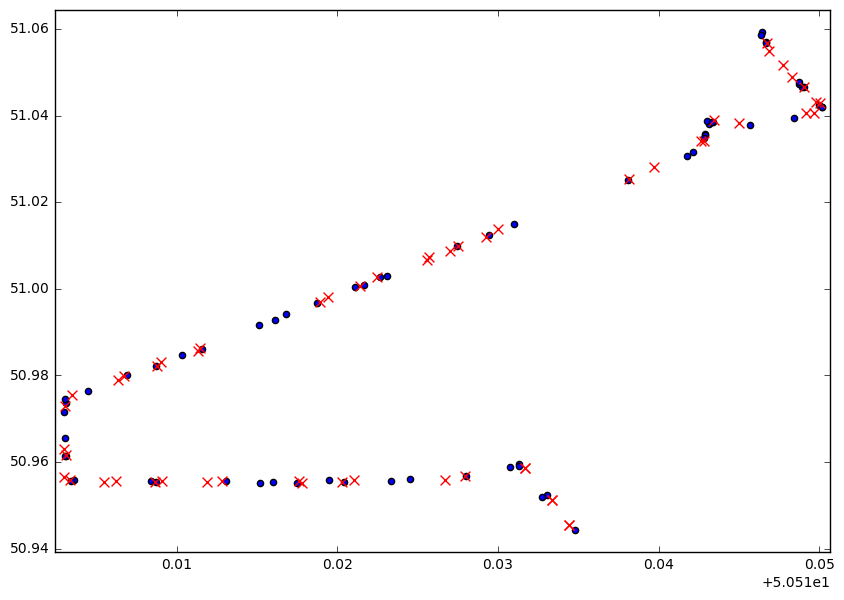

In [17]:
target_bus_stops = target_stops[  (target_stops['transport_type'] == transport_type)
                                & (target_stops['route_id'] == route_id)]

travel_xs = single_travel['lat']
travel_ys = single_travel['lon']

fig = plt.figure(figsize=(10,7))
axes = plt.gca()
axes.set_xlim([0.99999 * min(travel_xs), 1.00001 * max(travel_xs)])
axes.set_ylim([0.9999 * min(travel_ys), 1.0001 * max(travel_ys)])

plt.scatter(travel_xs, travel_ys)
plt.scatter(target_bus_stops['lat'], target_bus_stops['lon'], marker='x', color='red', s=50)
plt.show()

In [18]:
from math import radians, cos, sin, asin, sqrt
def parse_timestamp(time_in_secs):    
    return datetime.datetime.fromtimestamp(int(time_in_secs) / 1e6)

def df_dist(row):
    return haversine(row['Lon'], row['Lat'], row['Lon_prev'], row['Lat_prev'])

def numpy_dist(row):
    return haversine(row[0], row[1], row[2], row[3])

def df_speed(row):
    if not row['Time deltas'].total_seconds():
        return 0
    m_s = row['Traveled dist'] * 1000 / row['Time deltas'].total_seconds()
    km_h = m_s * 3.6
    return km_h

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [19]:
%%time
from timeit import default_timer
idx = 0
df_with_speeds = []
unique_line_ids = df['route_id'].unique()
print(len(unique_line_ids), 'unique line ids')

for line_id in unique_line_ids:
    line_id_df = df[df['route_id'] == line_id]
    
    unique_transports = line_id_df['transport_id'].unique()
    print(len(unique_transports), 'unique transports')

    t = default_timer()
    for transport_id in unique_transports:
        idx += 1
        if idx % 100 == 0:
            print(idx, default_timer() - t)
            t = default_timer()

        journey_df = line_id_df[line_id_df['transport_id'] == transport_id]
        if len(journey_df) < 2:        
            continue

        journey_df = journey_df.sort_values('timestamp')
        journey_df = journey_df.join(journey_df[['timestamp', 'lon', 'lat']].shift(), rsuffix='_prev')
        journey_df['Time deltas'] = journey_df['timestamp'] - journey_df['timestamp_prev']
        journey_df['Time deltas sec'] = journey_df['Time deltas'].astype('timedelta64[s]')
        journey_df['Traveled dist'] = np.apply_along_axis(numpy_dist, 1, journey_df[['lon', 'lat', 'lon_prev', 'lat_prev']].values)
        journey_df['Speed'] = 3600 * journey_df['Traveled dist'] / journey_df['Time deltas sec']    
        journey_df.loc[journey_df['Time deltas sec'] == 0, 'Speed'] = 0
        
        df_with_speeds.append(journey_df)

df_with_speeds = pd.concat(df_with_speeds)

224 unique line ids
35 unique transports
7 unique transports
31 unique transports
26 unique transports
40 unique transports
100 7.245999995575403e-05
25 unique transports
6 unique transports
17 unique transports
12 unique transports
31 unique transports
200 7.137100010368158e-05
38 unique transports
32 unique transports
300 0.38948126500008584
4 unique transports
12 unique transports
16 unique transports
14 unique transports
32 unique transports
51 unique transports
400 0.20111618299984002
30 unique transports
37 unique transports
22 unique transports
500 0.03282519499998671
11 unique transports
32 unique transports
36 unique transports
16 unique transports
600 0.02776401000005535
19 unique transports
19 unique transports
25 unique transports
46 unique transports
700 0.18773976700003914
49 unique transports
11 unique transports
18 unique transports
800 0.39552261700009694
21 unique transports
13 unique transports
4 unique transports
57 unique transports
18 unique transports
900 0.10896

In [22]:
lat_min = df['lat'].min()
lat_range = df['lat'].max() - lat_min
lon_min = df['lon'].min()
lon_range = df['lon'].max() - lon_min
print(lat_min, lon_min, df['lat'].max(), df['lon'].max())
num_cells_lat = 800
num_cells_lon = 2000
lat_step = lat_range / num_cells_lat
lon_step = lon_range / num_cells_lon
print(lat_step)
print('lat step: {:.2f}km'.format(haversine(0, 0, lat_step, 0)))
print('lon step: {:.2f}km'.format(haversine(0, 0, lon_step, 0)))

50.296417 50.145202 51.046154 52.058666
0.00093717125
lat step: 0.10km
lon step: 0.11km


In [23]:
import pickle
clf = pickle.load(open('clf.pickle', 'rb'))

0 0.00098252899988438 num answers: 0
1 2.5134046840003066 num answers: 0
2 2.496957491000103 num answers: 0
3 2.4499372270001913 num answers: 0
4 2.4299935589997403 num answers: 0
5 2.43796334200033 num answers: 0
6 2.406931443000758 num answers: 0
7 2.362492294999356 num answers: 0
8 2.406083844999557 num answers: 0
9 2.4162685470000724 num answers: 0
10 2.4338240259994564 num answers: 0
11 2.4531926100007695 num answers: 0
12 2.426871482000024 num answers: 0
13 2.4366368180008067 num answers: 0
14 2.413095580999652 num answers: 0
15 2.446496591000141 num answers: 0
16 2.5462089029997514 num answers: 0
17 2.485475760000554 num answers: 0
18 2.539877413000795 num answers: 0
19 2.5076224049998928 num answers: 0
20 2.4848730560006516 num answers: 0
21 2.6135017059996244 num answers: 0
22 2.4886855350005135 num answers: 0
23 2.476168309000059 num answers: 0
24 2.4761606409992964 num answers: 0
25 2.4643412870000247 num answers: 0
26 2.3896570680008153 num answers: 0
27 2.4305603100001463 

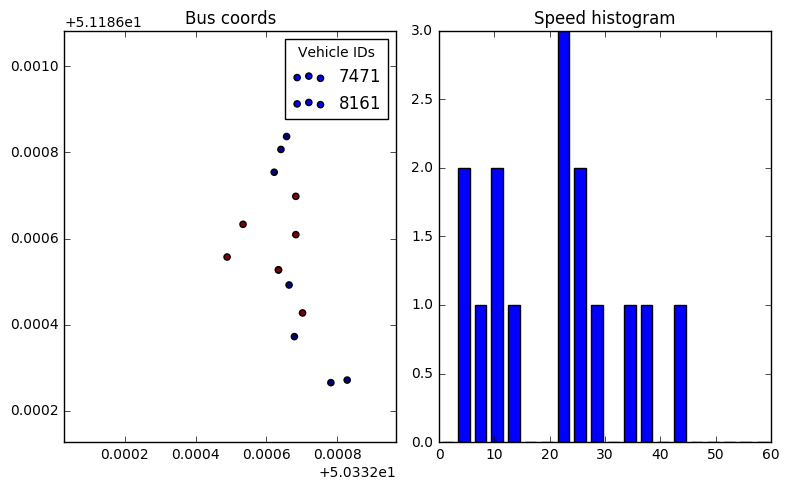

lat_idx 38 lon_idx 1088
Cell line ID 222
Num cell points 16
Num line points 1


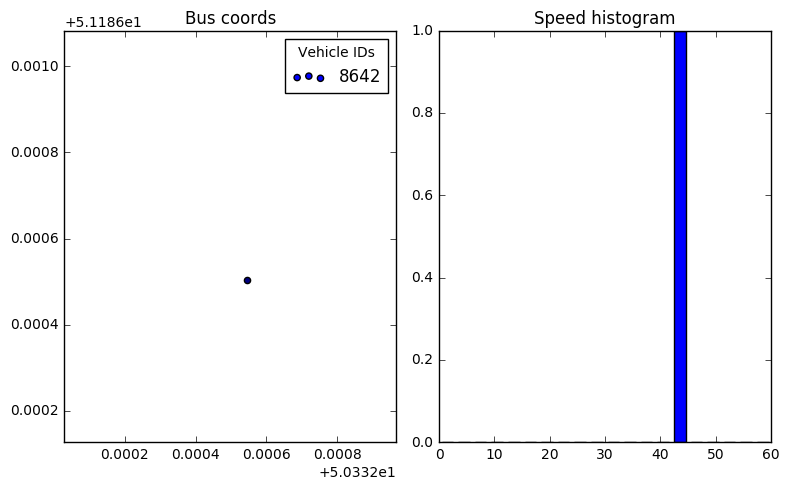

39 3.2954666060004456 num answers: 0
40 2.5642597470005057 num answers: 0
41 2.418897461000597 num answers: 0
42 2.5730109449996235 num answers: 0
43 2.3952323289995547 num answers: 0
44 2.5441402710002876 num answers: 0
45 2.647839895999823 num answers: 0
46 2.5402452449998236 num answers: 0
47 2.368962440999894 num answers: 0
48 2.3779122650003046 num answers: 0
49 2.4107022600001073 num answers: 0
50 2.6092456300002596 num answers: 0
51 2.3716654589998143 num answers: 0
52 2.632030312000097 num answers: 0
176 [4 1 0 3 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 52 lon_idx 933
Cell line ID 176
[4 1 0 3 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 10
Num line points 10


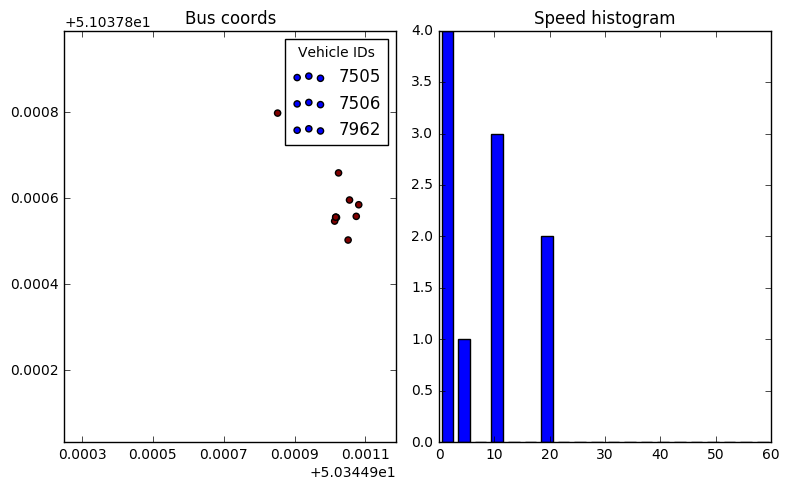

53 2.9033637860002273 num answers: 0
176 [1 1 0 1 2 1 0 1 0 2 1 0 0 0 0 0 0 0 0 0]
lat_idx 53 lon_idx 938
Cell line ID 176
[1 1 0 1 2 1 0 1 0 2 1 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 10
Num line points 10


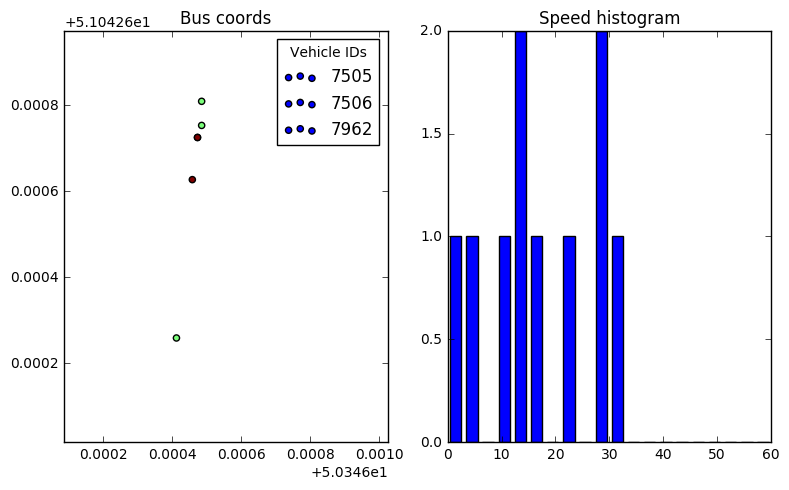

54 3.1094026350001513 num answers: 0
55 2.6796127440002238 num answers: 0
56 2.479523448000691 num answers: 0
57 2.5277193170004466 num answers: 0
58 2.494925783000326 num answers: 0
218 [1 0 0 1 3 3 3 1 0 1 0 0 0 0 0 0 0 0 0 0]
lat_idx 58 lon_idx 1153
Cell line ID 218
[1 0 0 1 3 3 3 1 0 1 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 13
Num line points 13


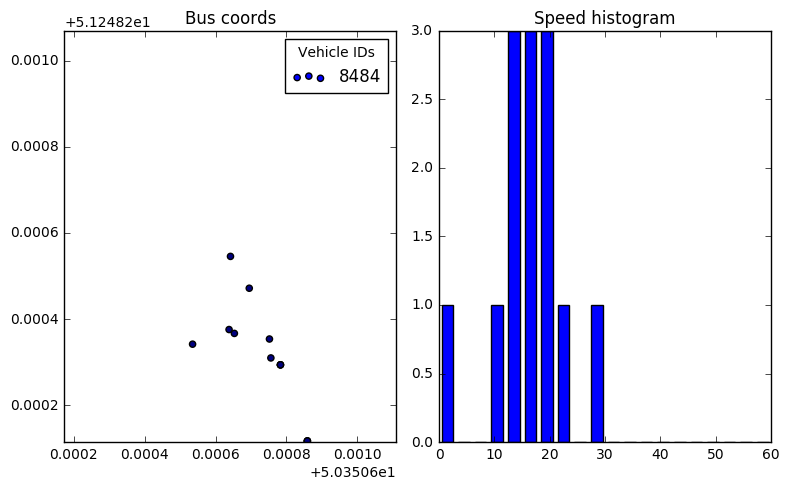

59 2.8581302000002324 num answers: 0
60 2.5711397929999293 num answers: 0
61 2.4504953079995175 num answers: 0
62 2.436259213000085 num answers: 0
63 2.4133844549996866 num answers: 0
64 2.42914729200038 num answers: 0
65 2.431020771000476 num answers: 0
66 2.4687830600005327 num answers: 0
110 [0 1 0 0 2 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
lat_idx 66 lon_idx 1157
Cell line ID 110
[0 1 0 0 2 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 17
Num line points 6


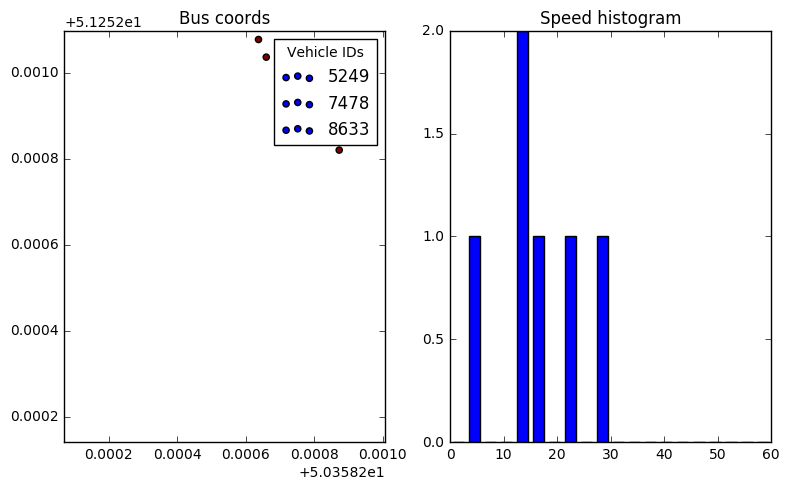

115 [0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
lat_idx 66 lon_idx 1157
Cell line ID 115
[0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 17
Num line points 3


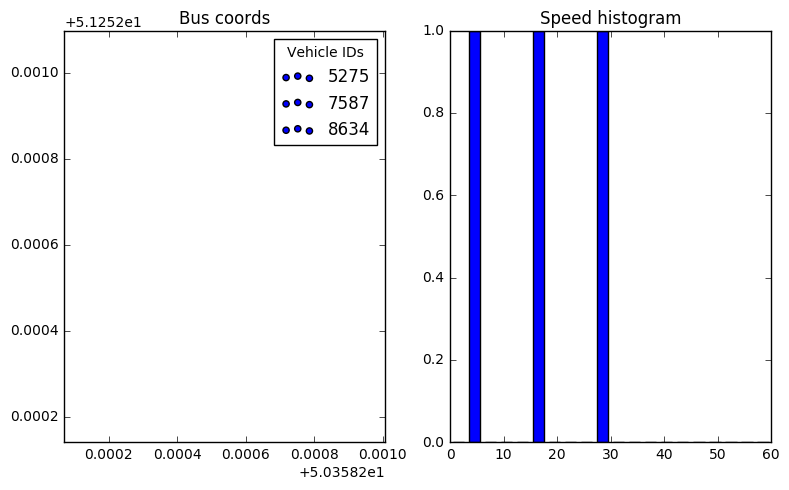

173 [1 0 0 0 1 2 3 0 1 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 66 lon_idx 1157
Cell line ID 173
[1 0 0 0 1 2 3 0 1 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 17
Num line points 8


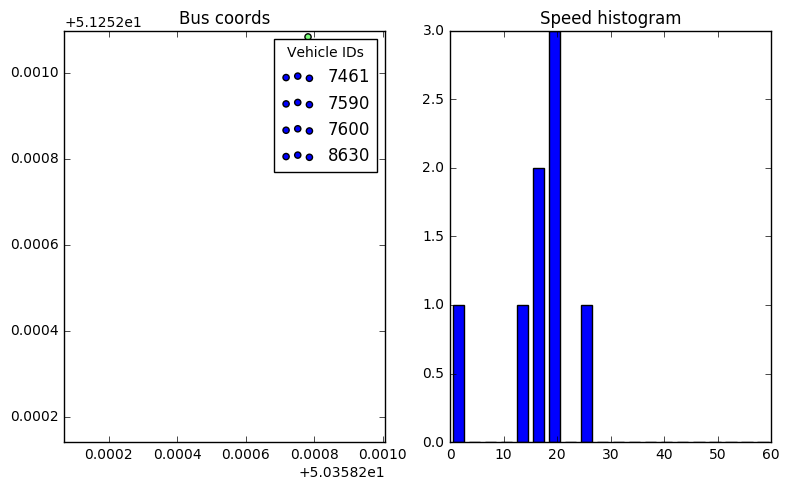

110 [1 0 0 0 0 2 2 0 2 0 1 0 0 0 0 0 0 0 0 0]
lat_idx 66 lon_idx 1158
Cell line ID 110
[1 0 0 0 0 2 2 0 2 0 1 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 33
Num line points 8


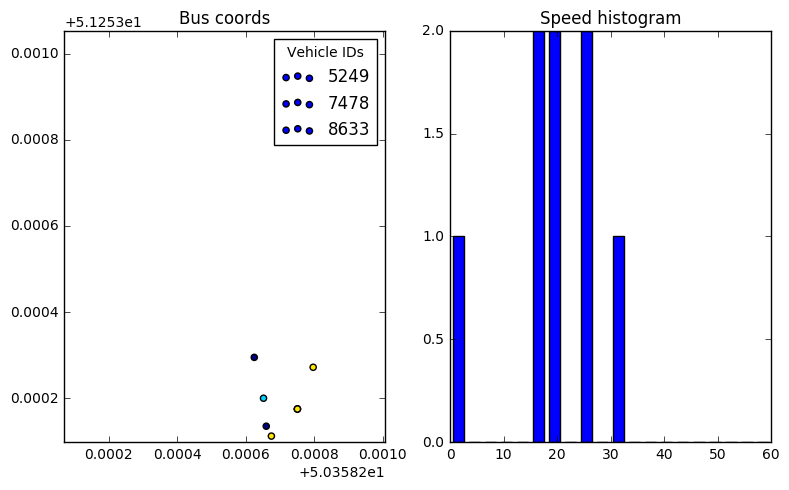

115 [2 0 0 1 1 0 2 1 0 1 0 0 0 0 0 0 0 0 0 0]
lat_idx 66 lon_idx 1158
Cell line ID 115
[2 0 0 1 1 0 2 1 0 1 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 33
Num line points 8


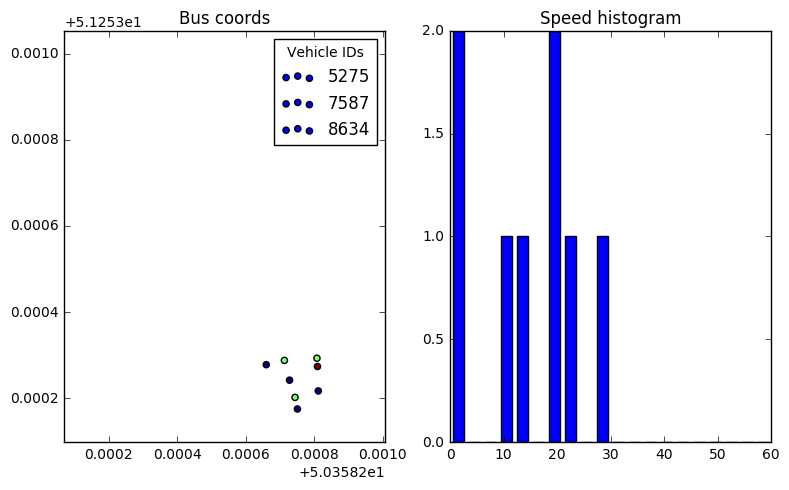

173 [0 0 0 0 3 5 1 6 2 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 66 lon_idx 1158
Cell line ID 173
[0 0 0 0 3 5 1 6 2 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 33
Num line points 17


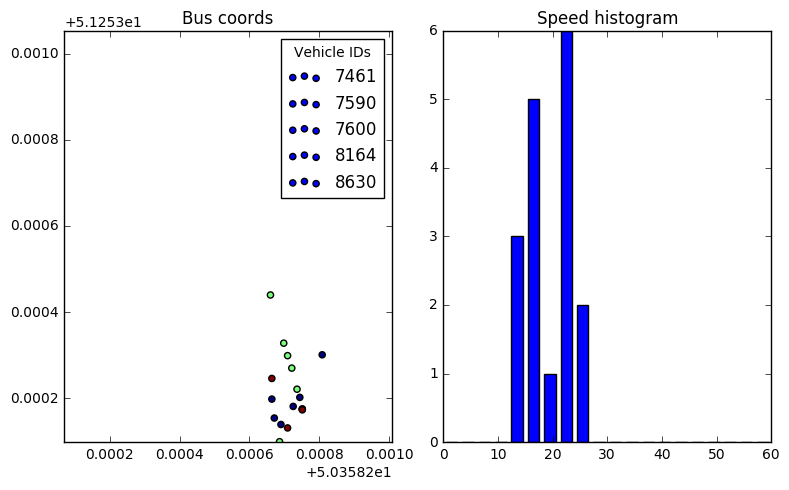

67 5.353149587000189 num answers: 0
68 2.5636089129993707 num answers: 0
176 [2 1 0 1 0 1 1 1 0 1 2 1 1 0 1 0 0 0 0 0]
lat_idx 68 lon_idx 939
Cell line ID 176
[2 1 0 1 0 1 1 1 0 1 2 1 1 0 1 0 0 0 0 0]
Is stop: [False]
Num cell points 14
Num line points 14


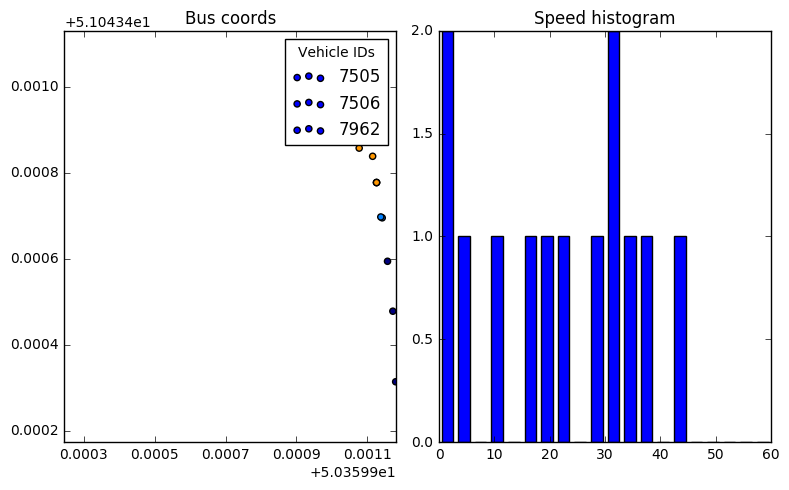

69 2.979064483000002 num answers: 0
110 [1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 69 lon_idx 1148
Cell line ID 110
[1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 16
Num line points 4


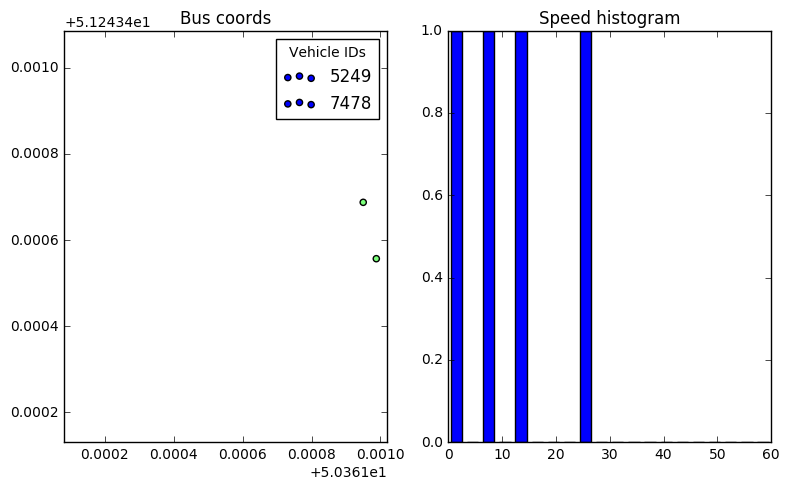

115 [0 1 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0]
lat_idx 69 lon_idx 1148
Cell line ID 115
[0 1 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 16
Num line points 5


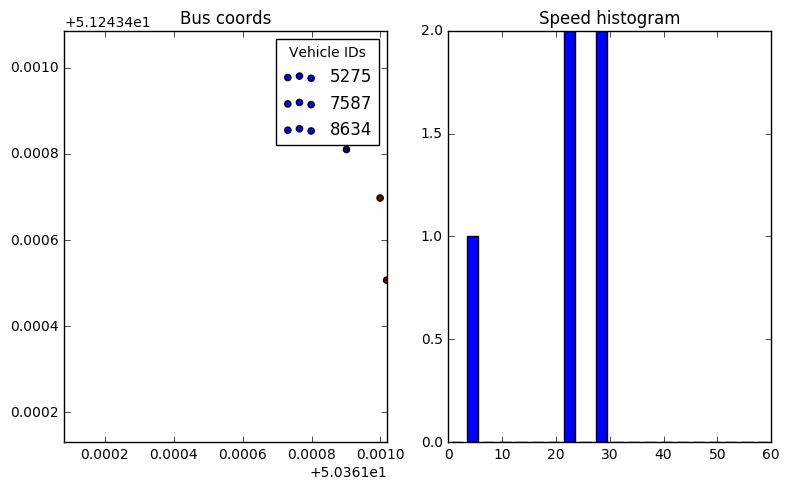

173 [0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0]
lat_idx 69 lon_idx 1148
Cell line ID 173
[0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 16
Num line points 7


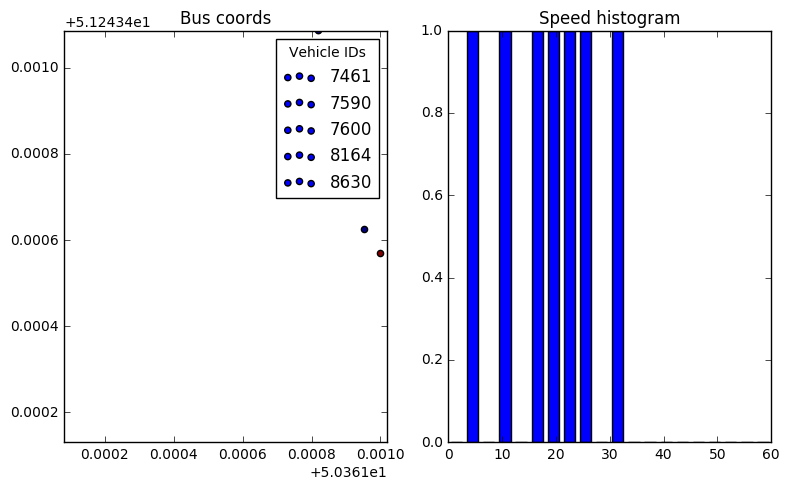

110 [0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 69 lon_idx 1150
Cell line ID 110
[0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 13
Num line points 2


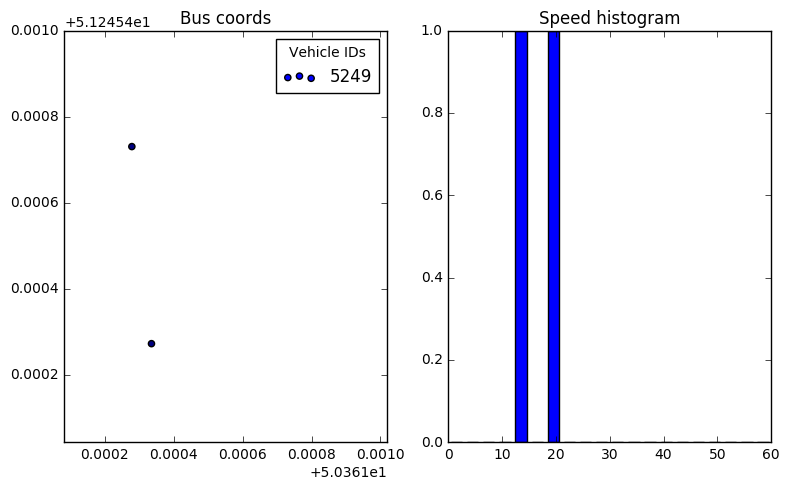

115 [1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
lat_idx 69 lon_idx 1150
Cell line ID 115
[1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 13
Num line points 4


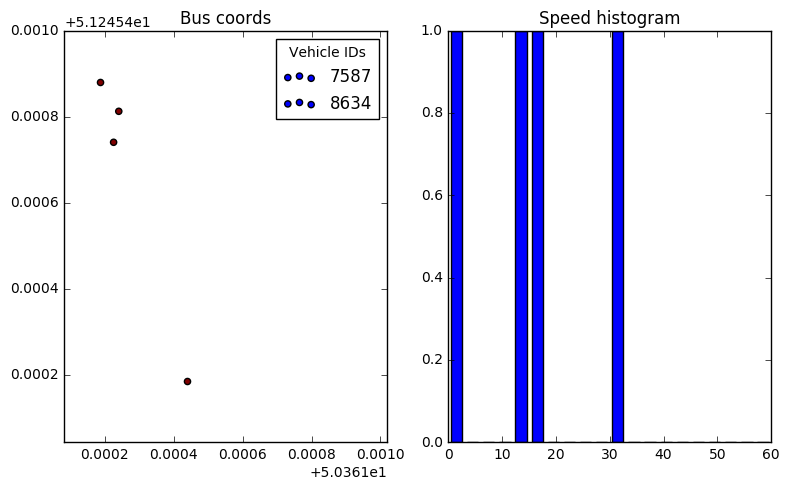

173 [0 0 0 0 0 3 1 2 1 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 69 lon_idx 1150
Cell line ID 173
[0 0 0 0 0 3 1 2 1 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 13
Num line points 7


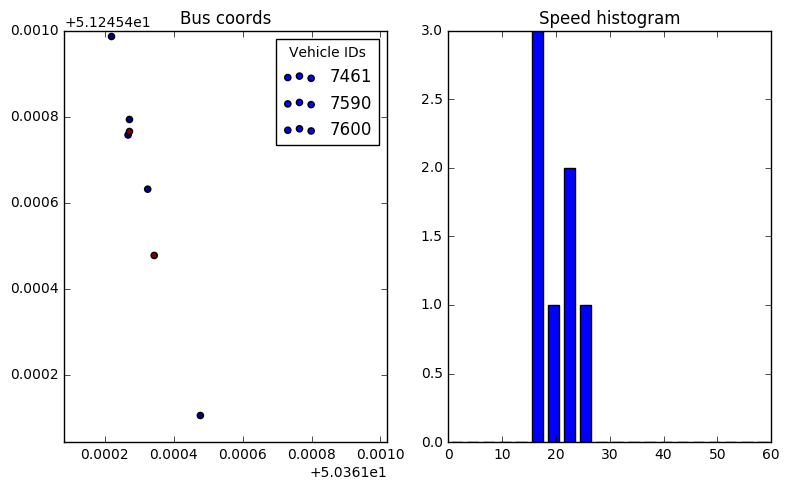

70 5.540547382000113 num answers: 0
110 [0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 70 lon_idx 1119
Cell line ID 110
[0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 15
Num line points 4


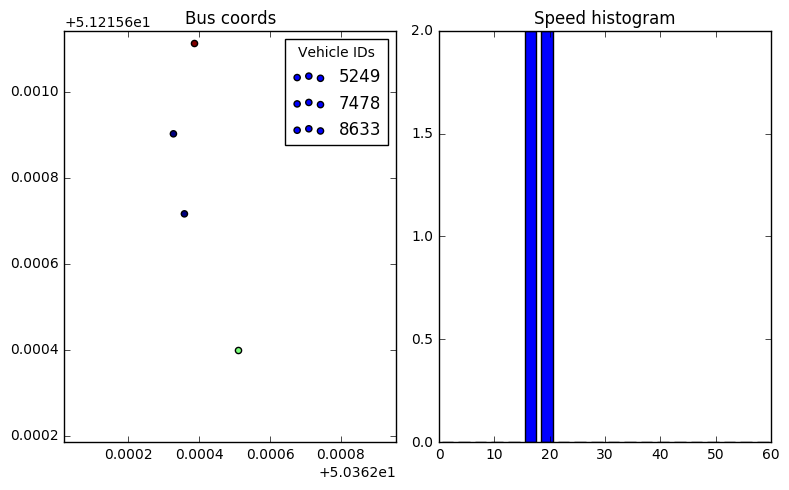

115 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 70 lon_idx 1119
Cell line ID 115
[0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 15
Num line points 3


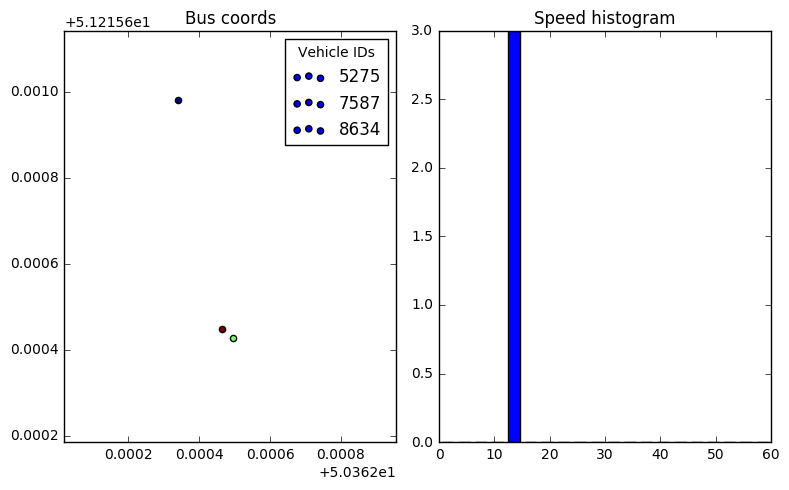

173 [0 0 0 0 3 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 70 lon_idx 1119
Cell line ID 173
[0 0 0 0 3 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 15
Num line points 6


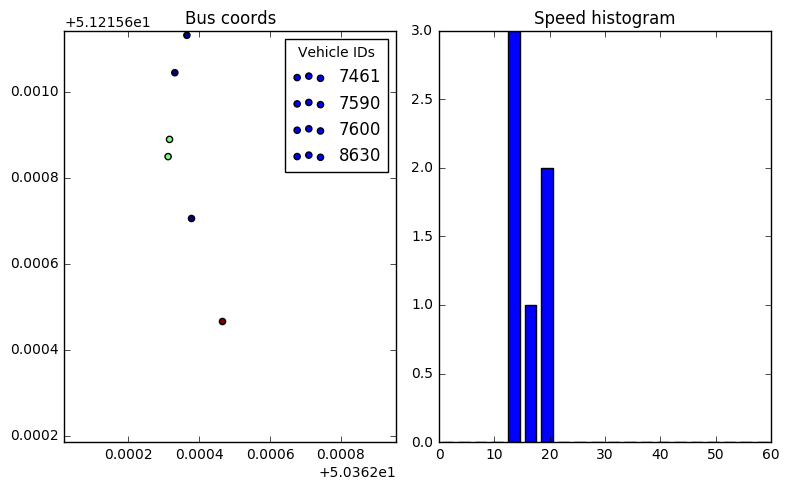

218 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 70 lon_idx 1119
Cell line ID 218
[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 15
Num line points 2


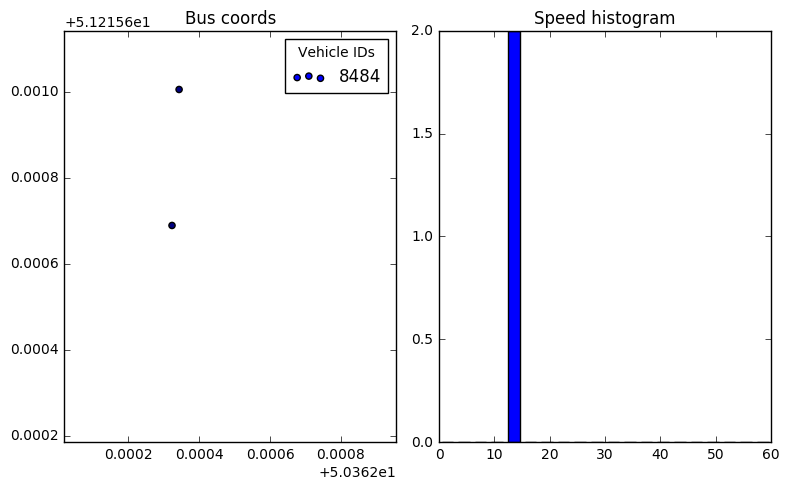

lat_idx 70 lon_idx 1123
Cell line ID 110
Num cell points 12
Num line points 1


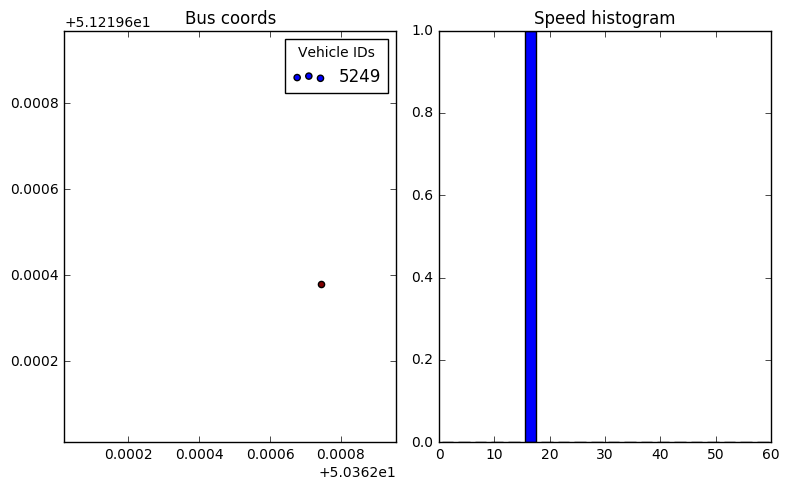

lat_idx 70 lon_idx 1123
Cell line ID 115
Num cell points 12
Num line points 1


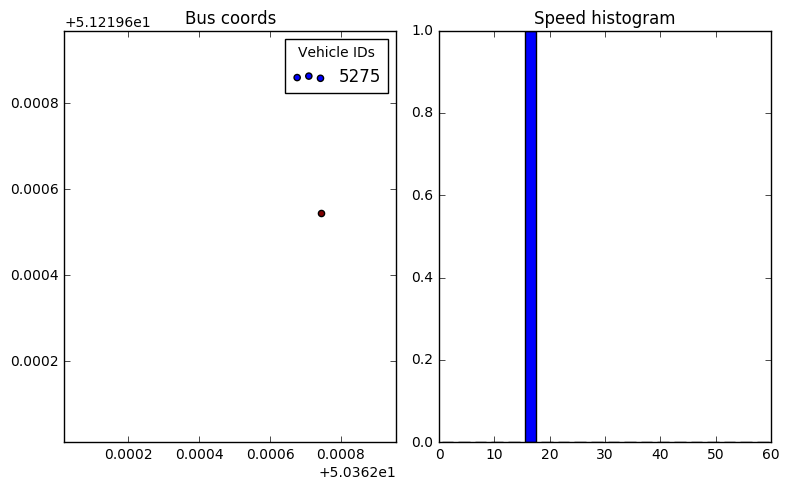

173 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 70 lon_idx 1123
Cell line ID 173
[0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 12
Num line points 3


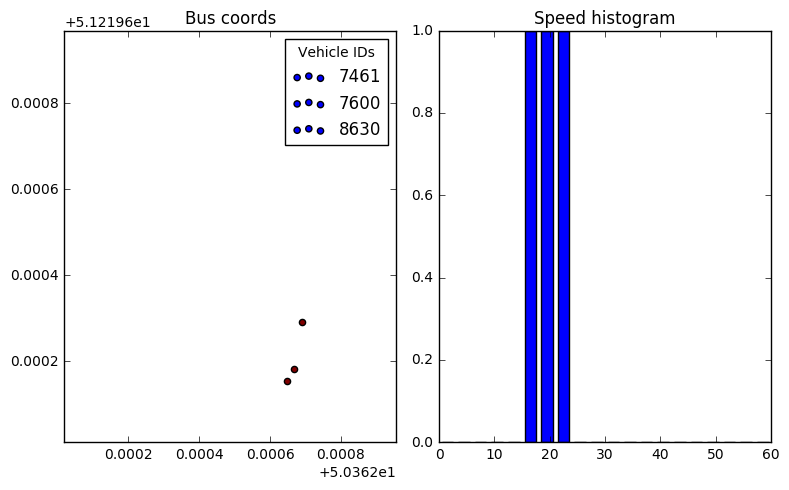

218 [0 0 0 1 0 3 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 70 lon_idx 1123
Cell line ID 218
[0 0 0 1 0 3 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 12
Num line points 7


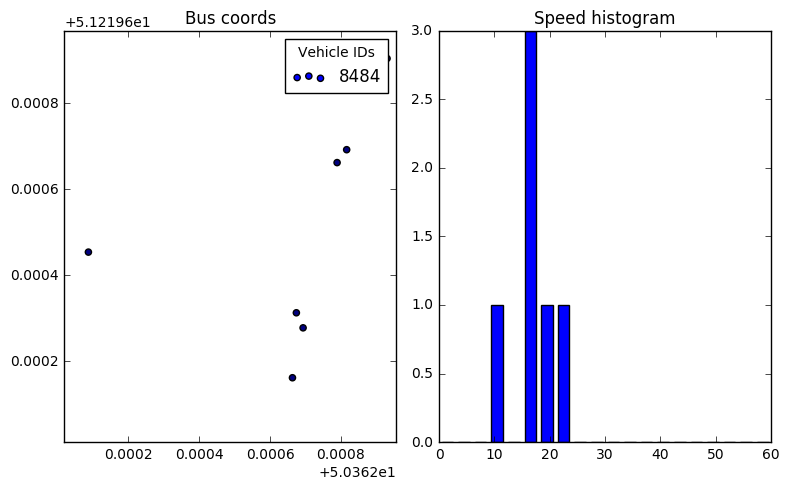

71 6.018175849999352 num answers: 0
115 [0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 71 lon_idx 1117
Cell line ID 115
[0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 17
Num line points 3


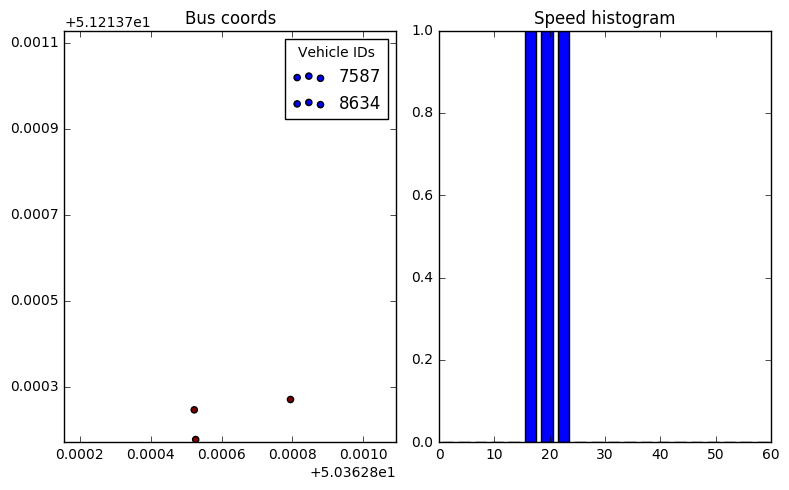

173 [0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 71 lon_idx 1117
Cell line ID 173
[0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 17
Num line points 4


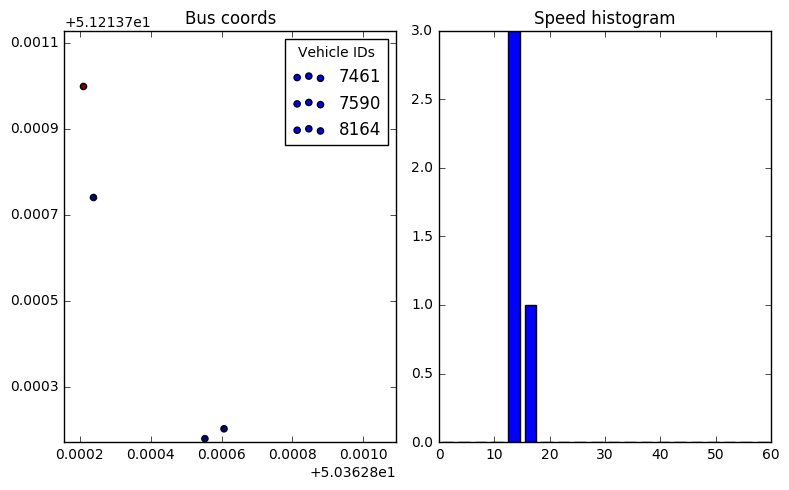

175 [0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0]
lat_idx 71 lon_idx 1117
Cell line ID 175
[0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 17
Num line points 4


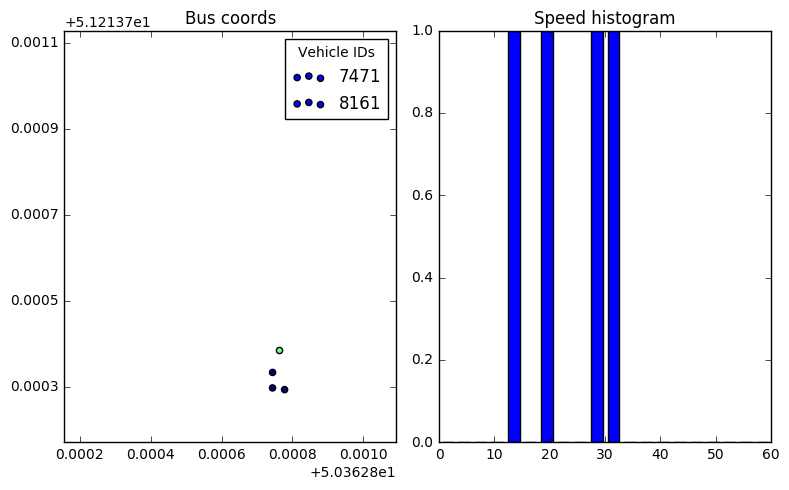

218 [0 0 0 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 71 lon_idx 1117
Cell line ID 218
[0 0 0 2 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 17
Num line points 4


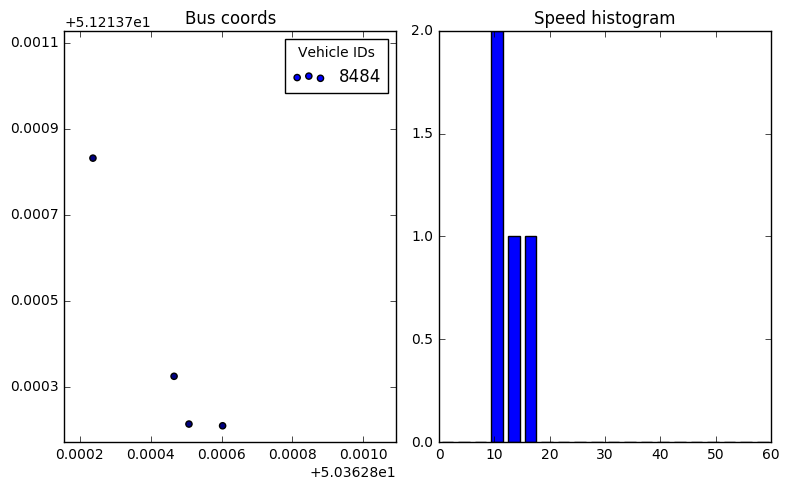

222 [0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
lat_idx 71 lon_idx 1117
Cell line ID 222
[0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 17
Num line points 2


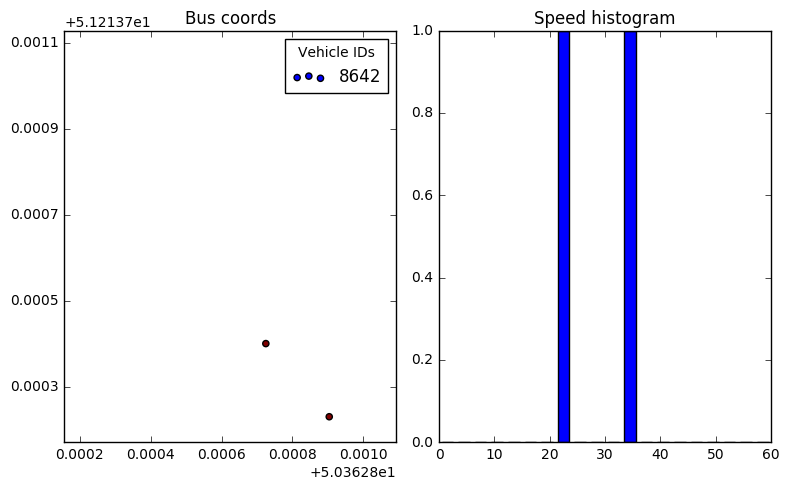

115 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 71 lon_idx 1122
Cell line ID 115
[0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 11
Num line points 2


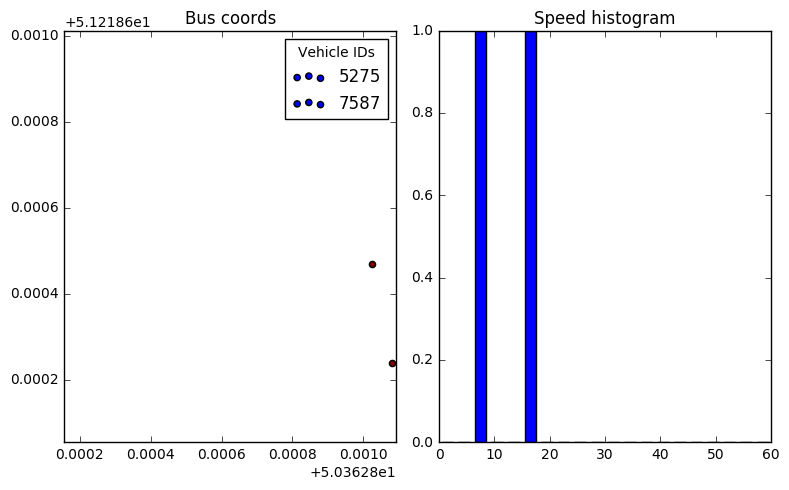

173 [0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0]
lat_idx 71 lon_idx 1122
Cell line ID 173
[0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 11
Num line points 5


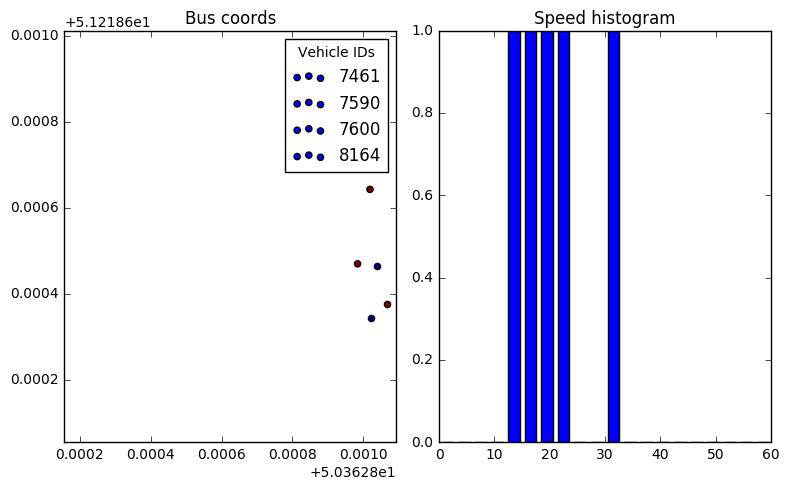

218 [0 0 0 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
lat_idx 71 lon_idx 1122
Cell line ID 218
[0 0 0 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 11
Num line points 4


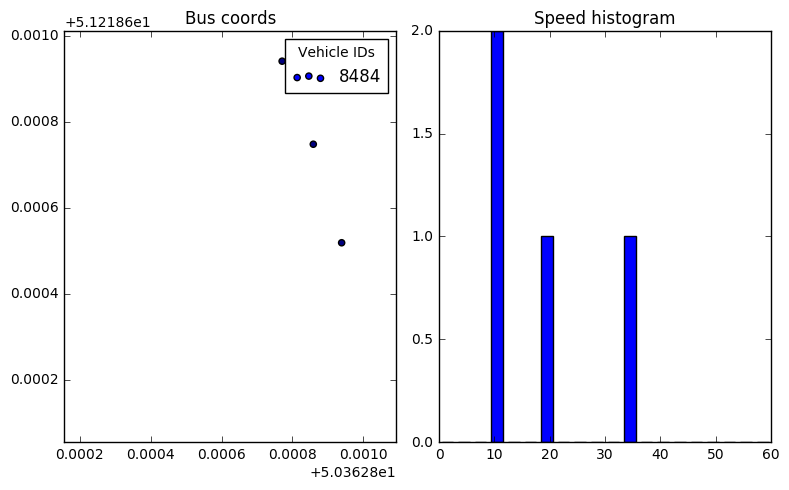

173 [0 0 0 0 1 1 0 2 0 0 0 0 0 1 0 0 0 0 0 0]
lat_idx 71 lon_idx 1124
Cell line ID 173
[0 0 0 0 1 1 0 2 0 0 0 0 0 1 0 0 0 0 0 0]
Is stop: [False]
Num cell points 11
Num line points 5


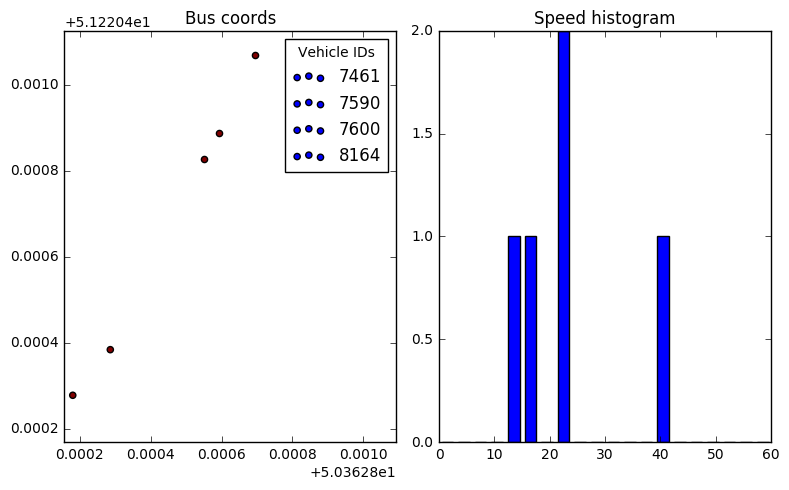

218 [0 0 0 0 1 3 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 71 lon_idx 1124
Cell line ID 218
[0 0 0 0 1 3 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 11
Num line points 6


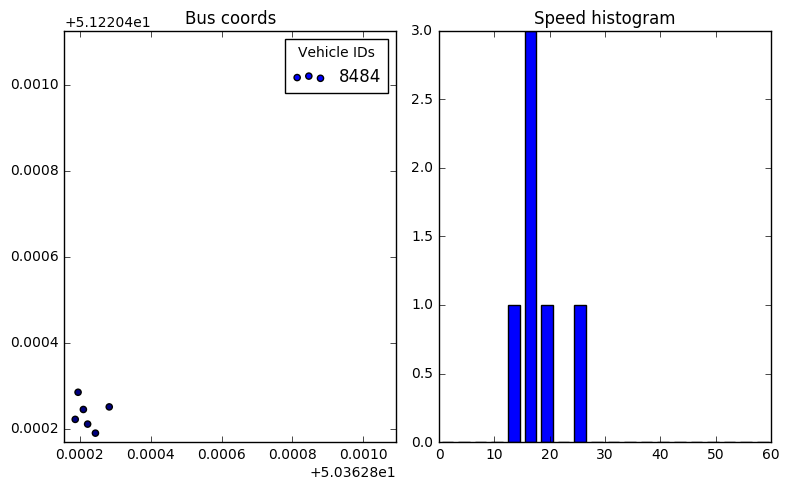

72 7.139067191999857 num answers: 0
lat_idx 72 lon_idx 1117
Cell line ID 110
Num cell points 12
Num line points 1


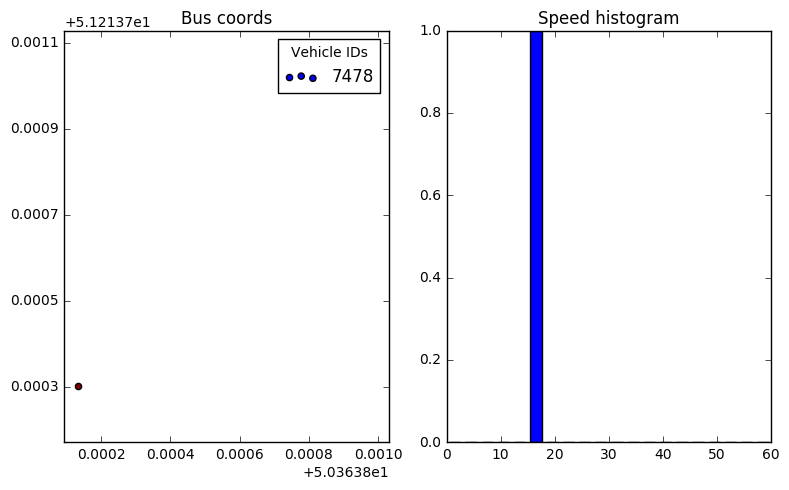

115 [0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1117
Cell line ID 115
[0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 12
Num line points 3


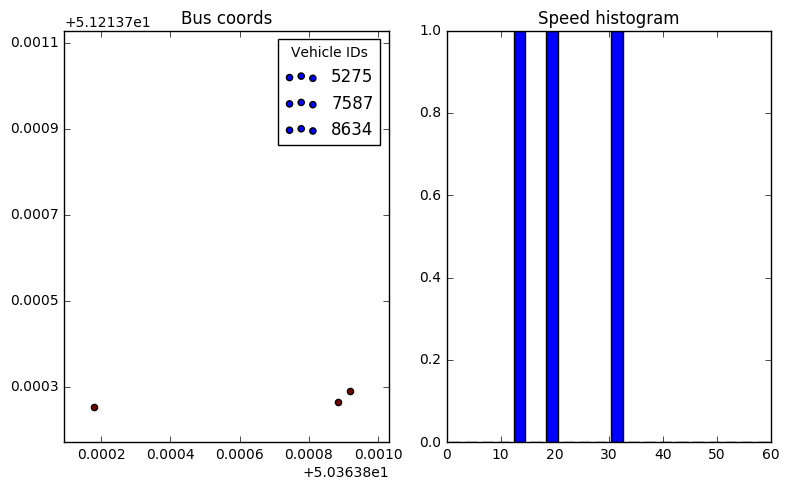

175 [0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1117
Cell line ID 175
[0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 12
Num line points 3


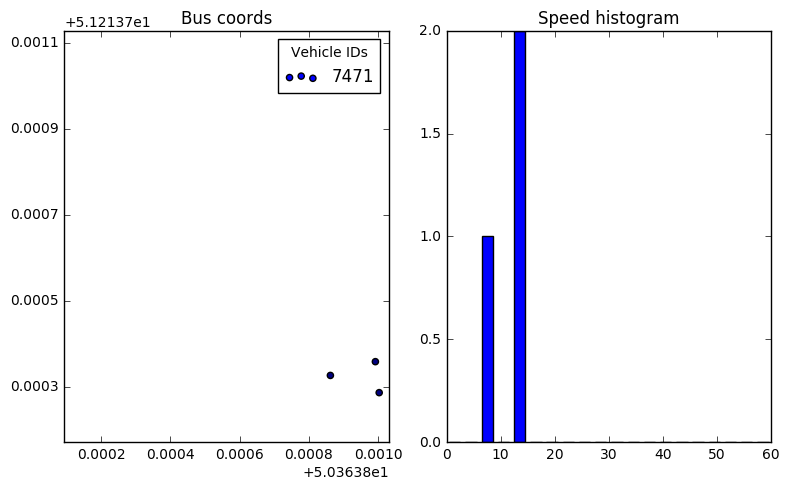

218 [0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1117
Cell line ID 218
[0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 12
Num line points 3


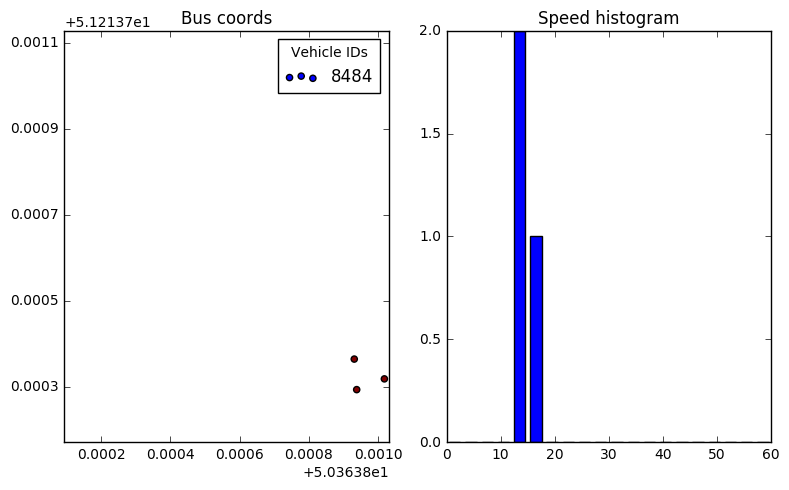

222 [0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1117
Cell line ID 222
[0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 12
Num line points 2


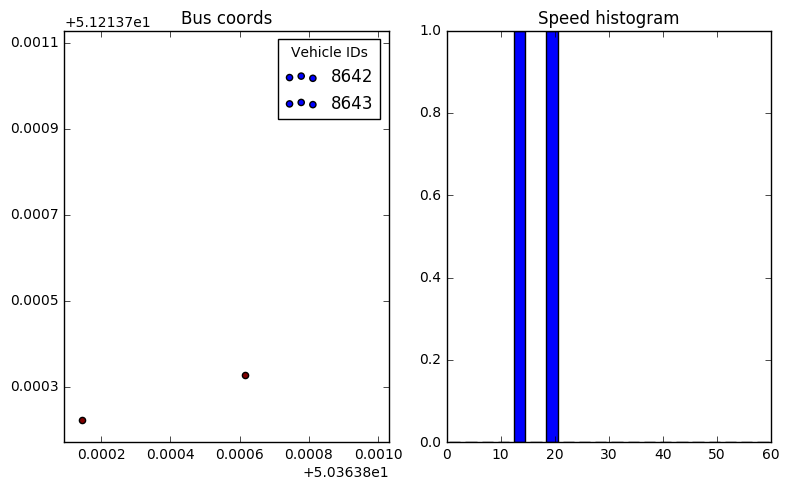

110 [0 0 0 0 0 0 4 0 1 1 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1121
Cell line ID 110
[0 0 0 0 0 0 4 0 1 1 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 13
Num line points 6


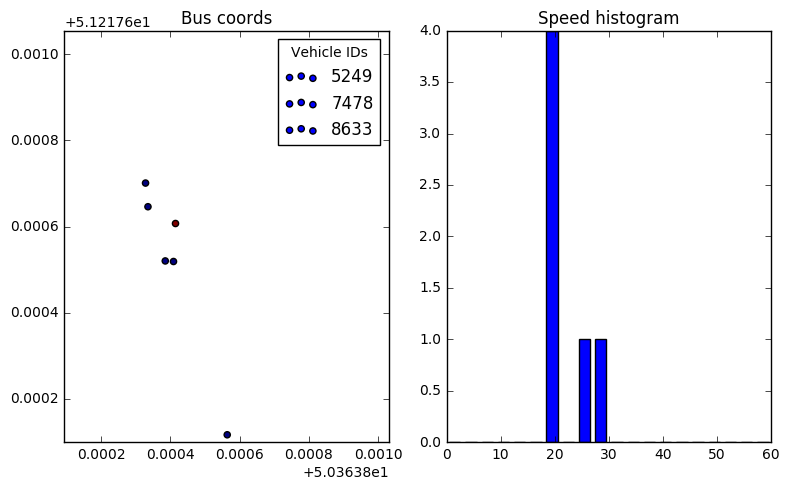

115 [0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1121
Cell line ID 115
[0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 13
Num line points 3


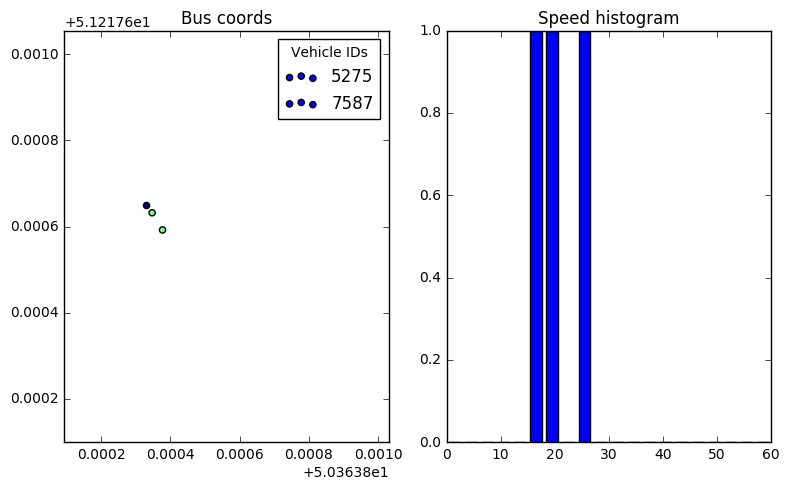

173 [0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1121
Cell line ID 173
[0 0 0 0 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 13
Num line points 3


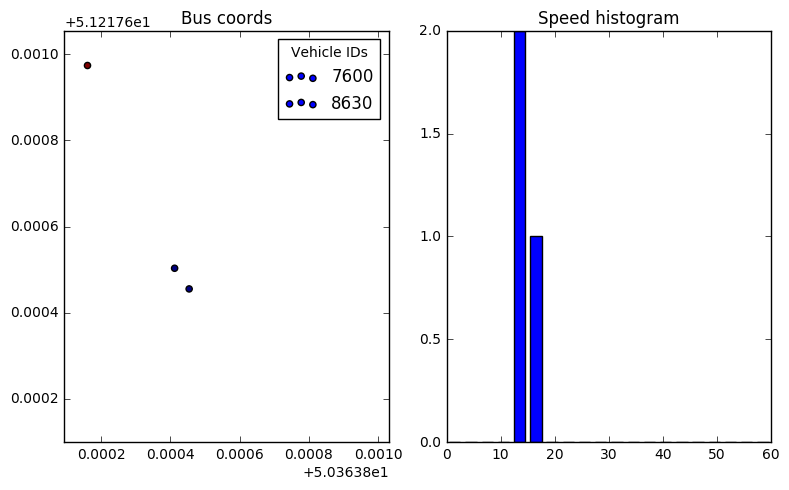

lat_idx 72 lon_idx 1121
Cell line ID 218
Num cell points 13
Num line points 1


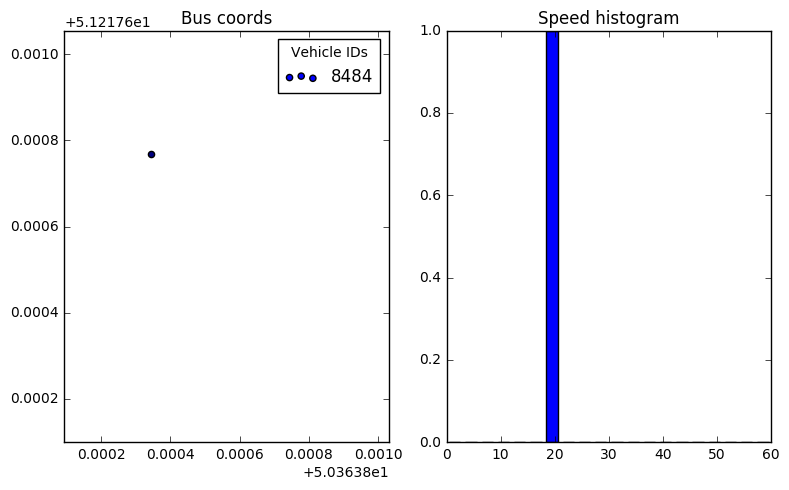

110 [0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1123
Cell line ID 110
[0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 11
Num line points 4


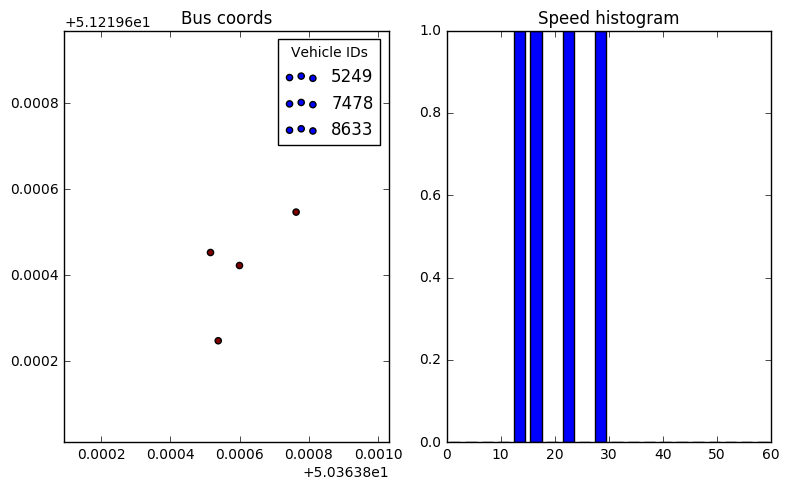

lat_idx 72 lon_idx 1123
Cell line ID 115
Num cell points 11
Num line points 1


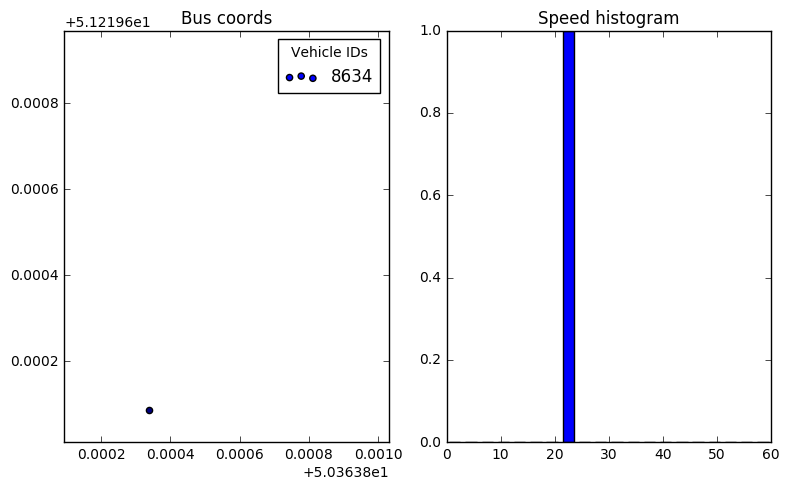

173 [0 0 0 0 0 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1123
Cell line ID 173
[0 0 0 0 0 2 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 11
Num line points 6


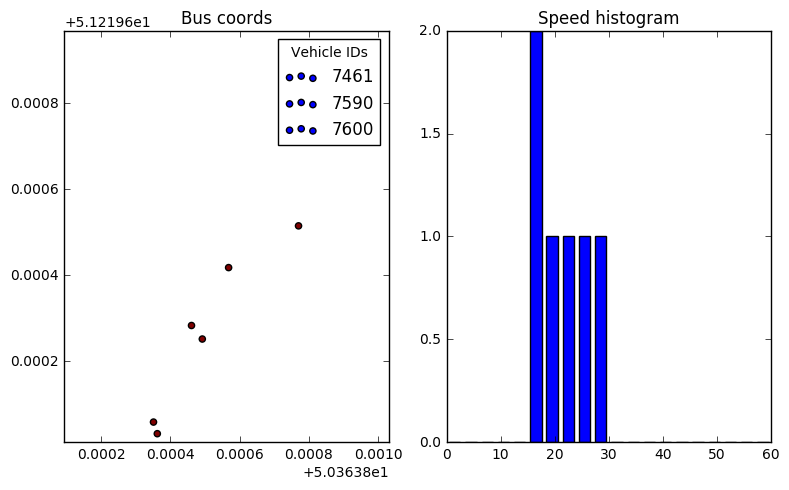

110 [0 0 0 2 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1132
Cell line ID 110
[0 0 0 2 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 13
Num line points 5


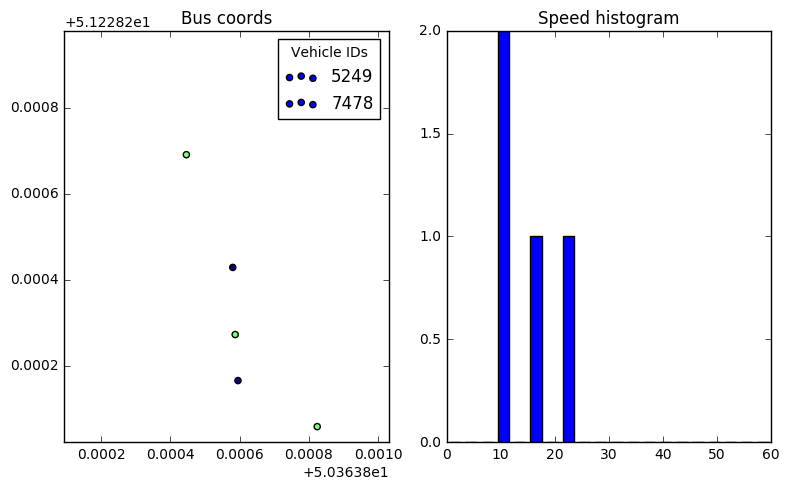

lat_idx 72 lon_idx 1132
Cell line ID 115
Num cell points 13
Num line points 1


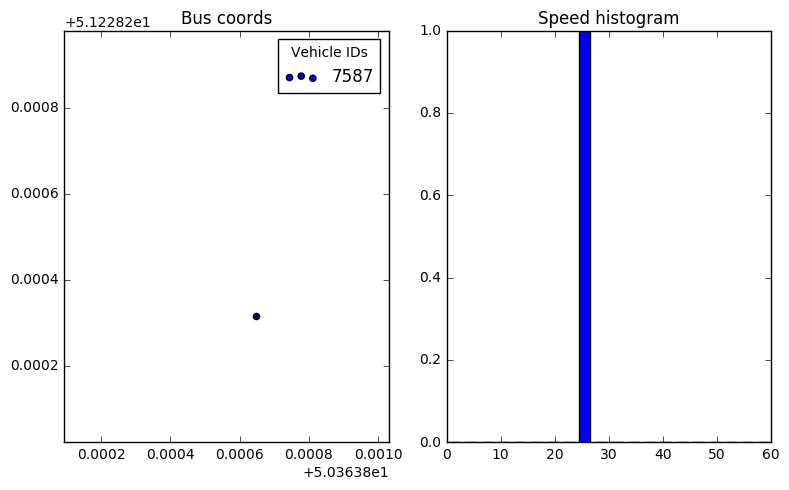

173 [1 0 0 2 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1132
Cell line ID 173
[1 0 0 2 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 13
Num line points 7


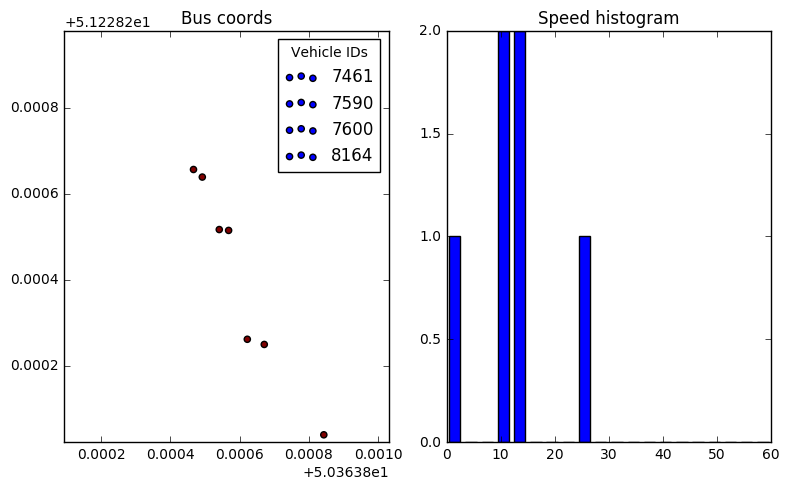

110 [1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1136
Cell line ID 110
[1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [ True]
Num cell points 11
Num line points 3


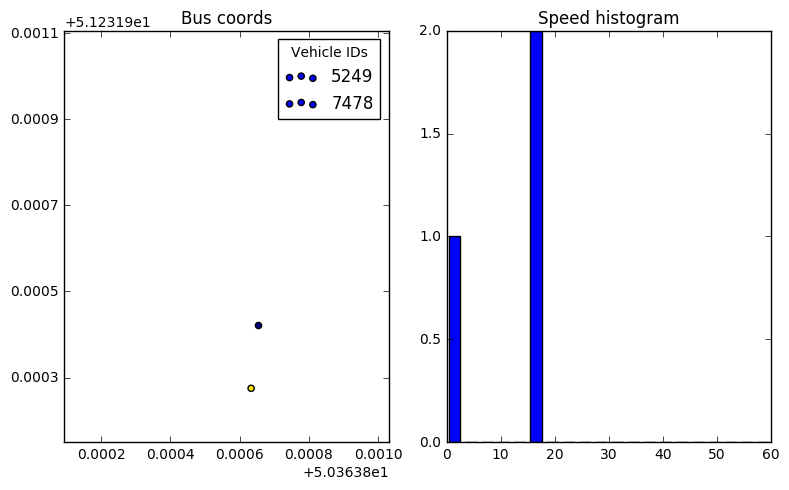

115 [0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1136
Cell line ID 115
[0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 11
Num line points 4


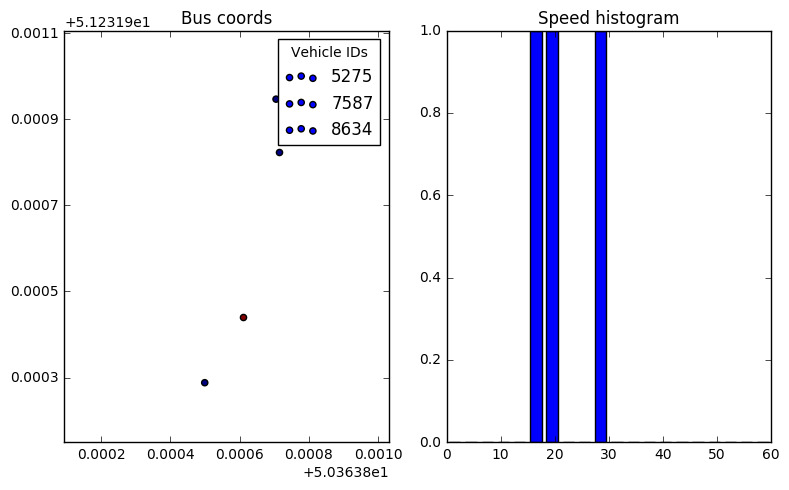

173 [0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1136
Cell line ID 173
[0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 11
Num line points 4


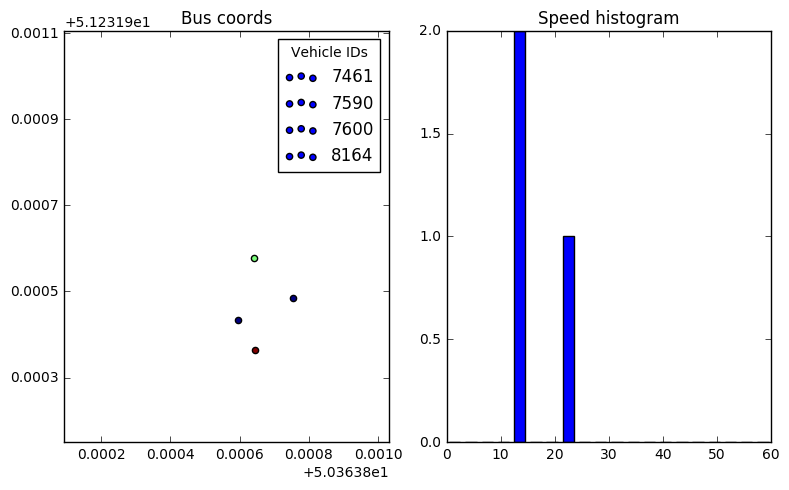

/home/sokolov/miniconda3/envs/bus-stops/lib/python3.5/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/home/sokolov/miniconda3/envs/bus-stops/lib/python3.5/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


110 [0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1137
Cell line ID 110
[0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 11
Num line points 4


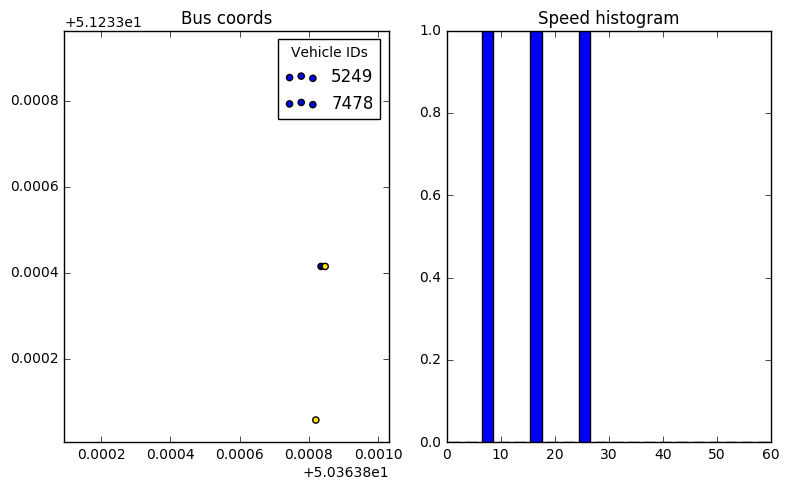

115 [0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1137
Cell line ID 115
[0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 11
Num line points 3


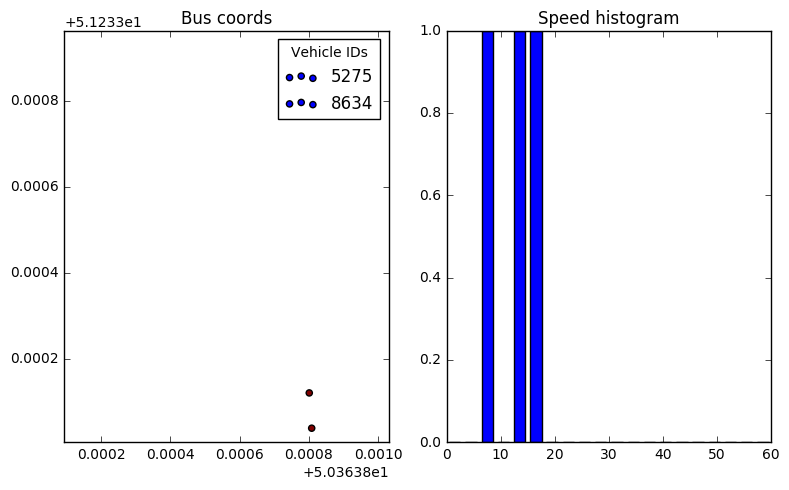

173 [0 0 0 2 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1137
Cell line ID 173
[0 0 0 2 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 11
Num line points 4


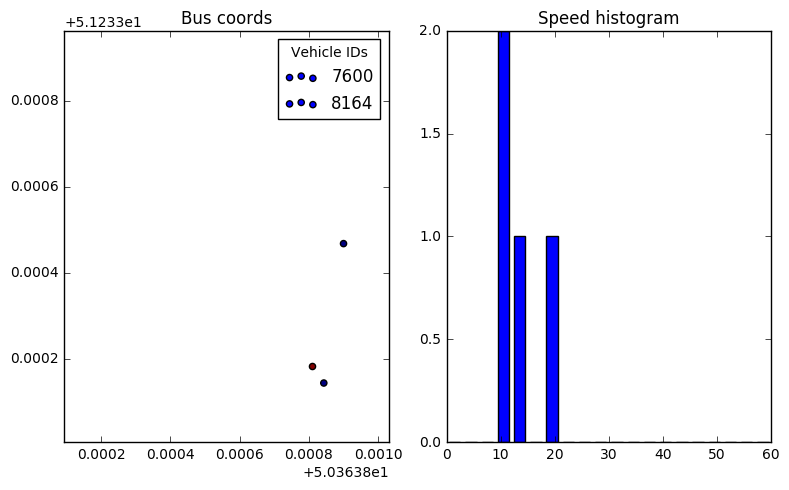

110 [1 0 0 0 1 1 2 0 0 0 0 1 0 1 0 0 0 0 0 0]
lat_idx 72 lon_idx 1138
Cell line ID 110
[1 0 0 0 1 1 2 0 0 0 0 1 0 1 0 0 0 0 0 0]
Is stop: [False]
Num cell points 20
Num line points 7


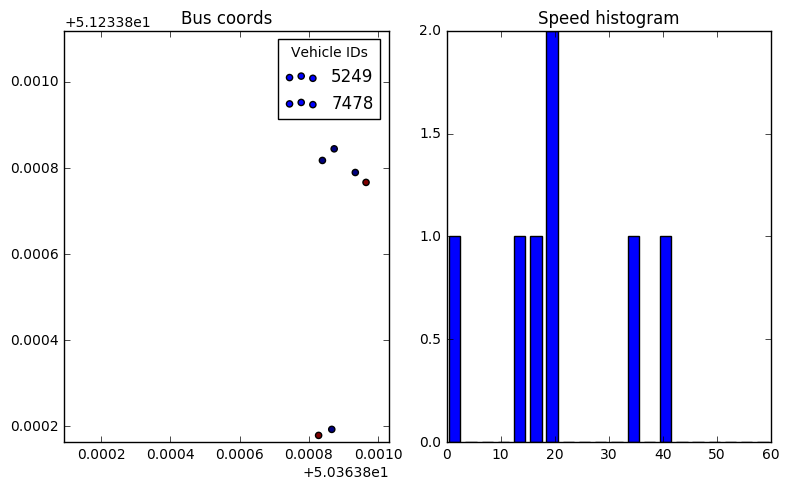

115 [0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1138
Cell line ID 115
[0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 20
Num line points 3


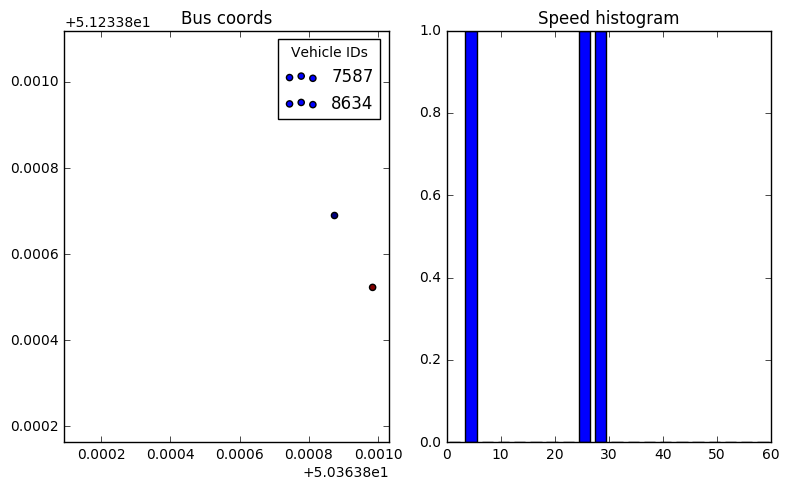

173 [0 1 1 0 1 2 2 1 1 1 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1138
Cell line ID 173
[0 1 1 0 1 2 2 1 1 1 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 20
Num line points 10


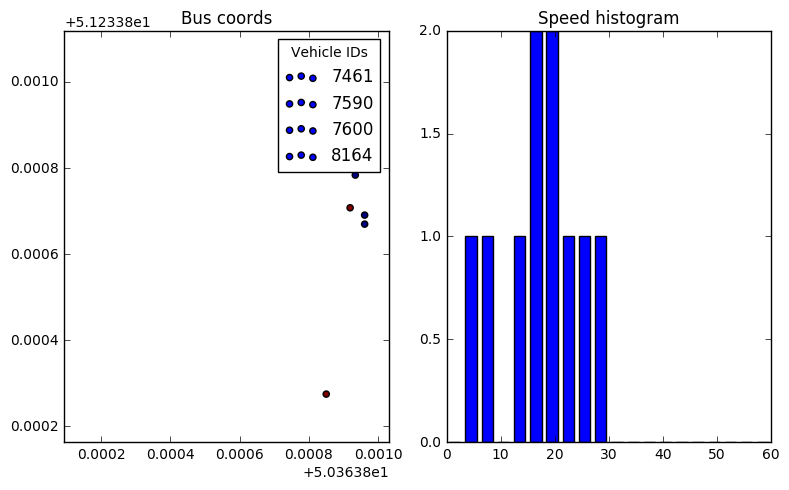

110 [1 0 0 2 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1140
Cell line ID 110
[1 0 0 2 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 19
Num line points 5


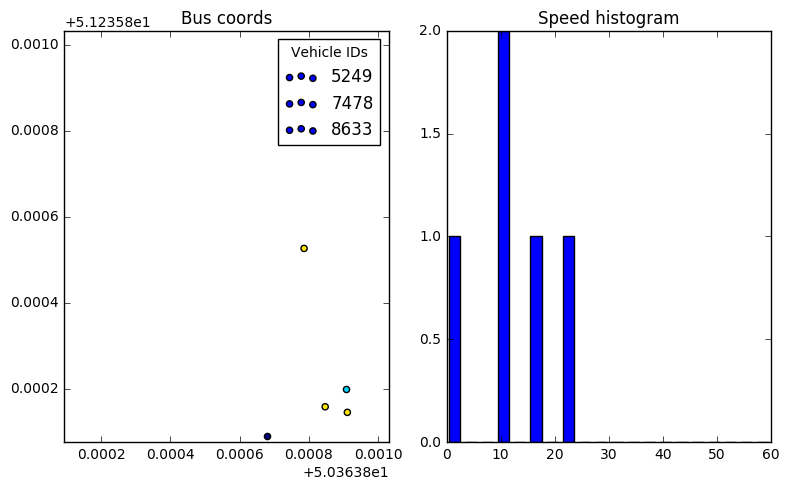

115 [0 0 0 0 0 1 4 0 1 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 72 lon_idx 1140
Cell line ID 115
[0 0 0 0 0 1 4 0 1 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 19
Num line points 6


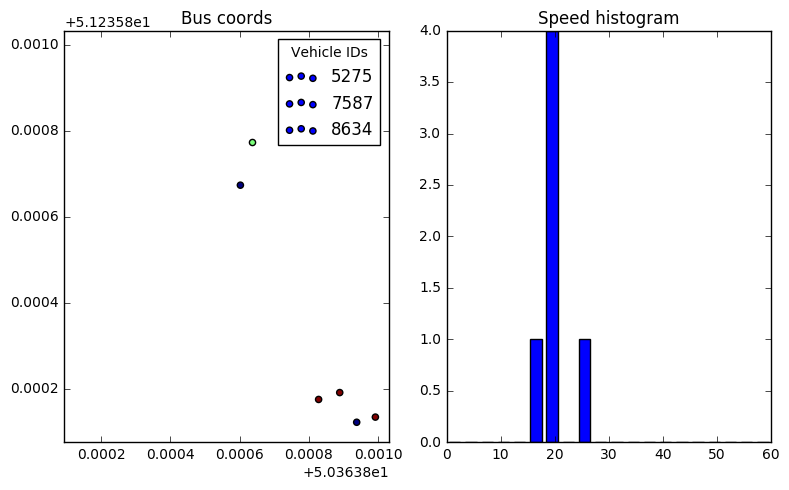

173 [0 0 0 1 0 2 3 1 0 0 0 0 0 0 0 1 0 0 0 0]
lat_idx 72 lon_idx 1140
Cell line ID 173
[0 0 0 1 0 2 3 1 0 0 0 0 0 0 0 1 0 0 0 0]
Is stop: [False]
Num cell points 19
Num line points 8


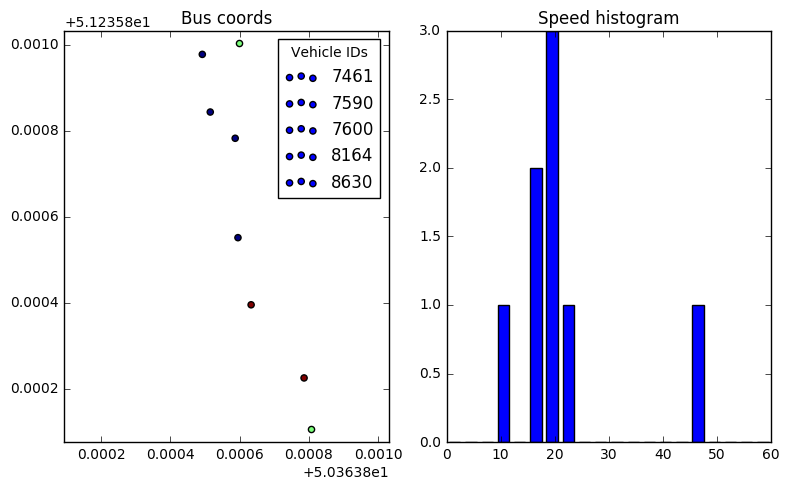

73 15.004769651999595 num answers: 1
110 [0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 73 lon_idx 1116
Cell line ID 110
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 10
Num line points 2


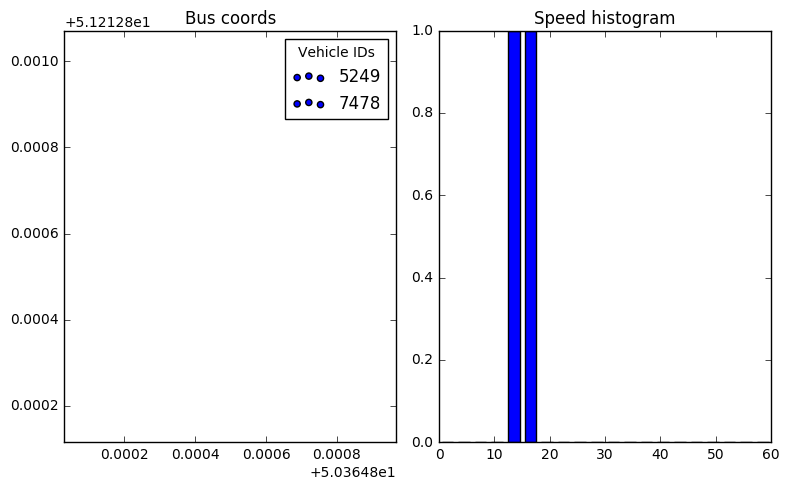

115 [0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 73 lon_idx 1116
Cell line ID 115
[0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 10
Num line points 2


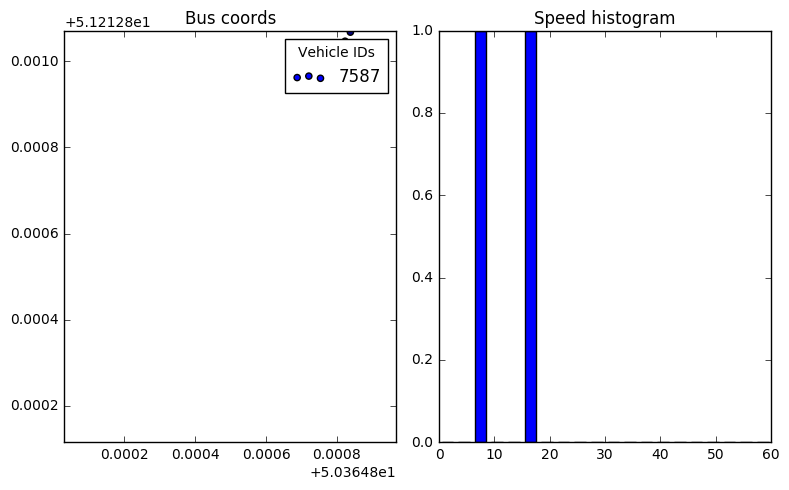

173 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 73 lon_idx 1116
Cell line ID 173
[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 10
Num line points 2


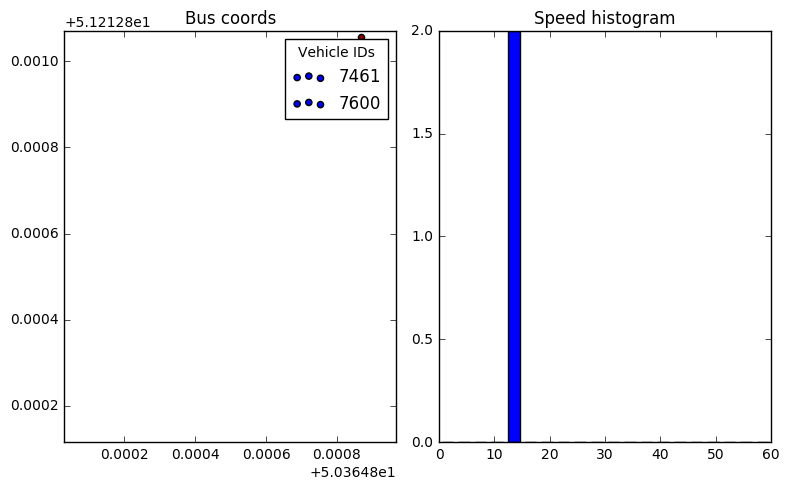

175 [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 73 lon_idx 1116
Cell line ID 175
[0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 10
Num line points 2


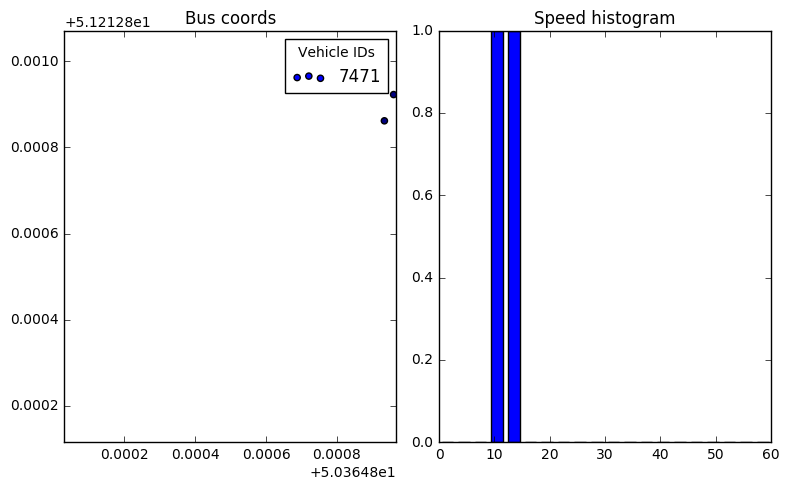

lat_idx 73 lon_idx 1116
Cell line ID 218
Num cell points 10
Num line points 1


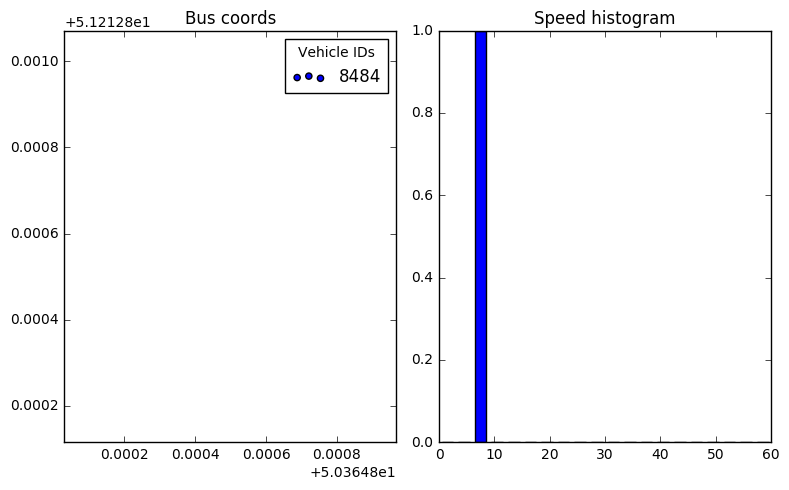

lat_idx 73 lon_idx 1116
Cell line ID 222
Num cell points 10
Num line points 1


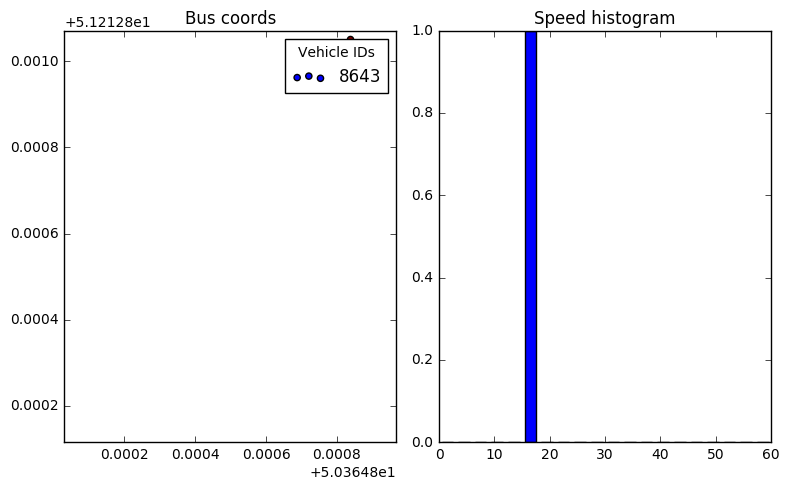

110 [0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 73 lon_idx 1117
Cell line ID 110
[0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 36
Num line points 5


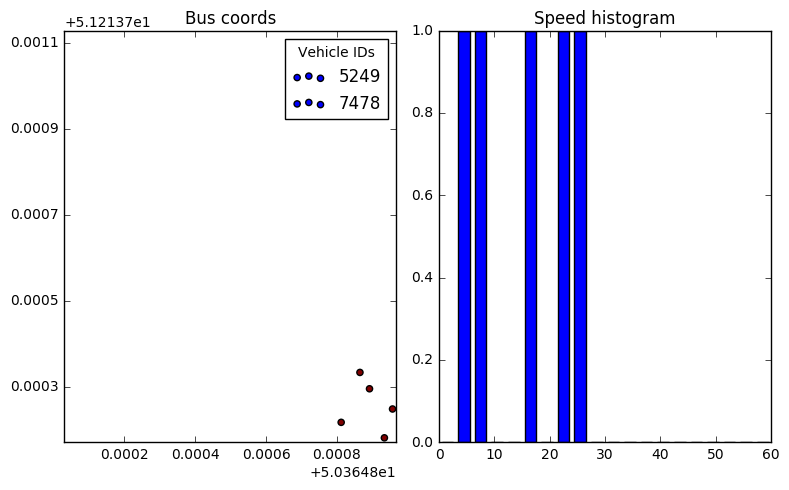

115 [0 0 0 1 1 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 73 lon_idx 1117
Cell line ID 115
[0 0 0 1 1 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 36
Num line points 6


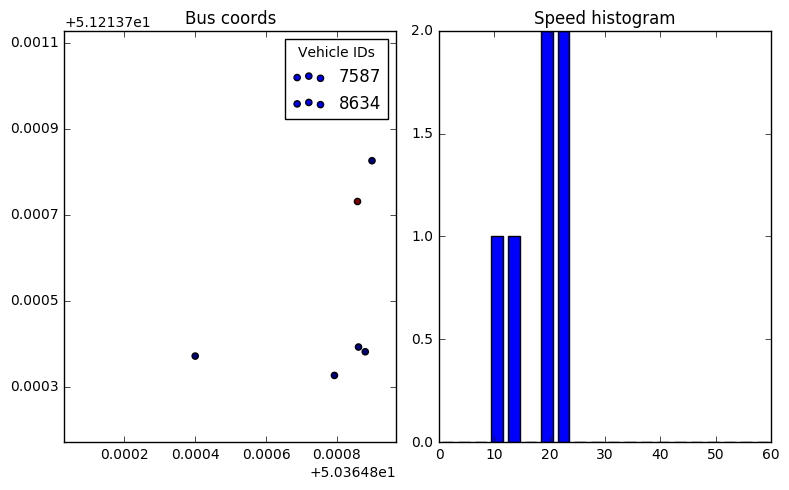

173 [0 0 0 1 3 3 2 1 0 0 0 0 0 0 1 0 0 0 0 0]
lat_idx 73 lon_idx 1117
Cell line ID 173
[0 0 0 1 3 3 2 1 0 0 0 0 0 0 1 0 0 0 0 0]
Is stop: [False]
Num cell points 36
Num line points 11


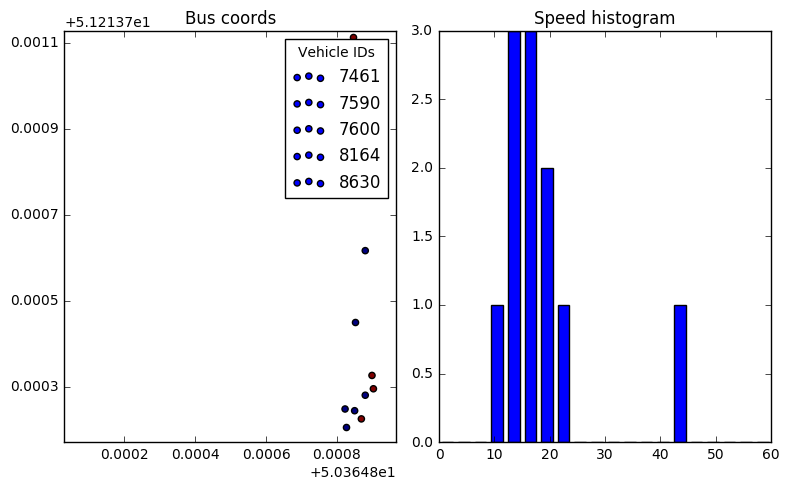

175 [0 0 0 1 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0]
lat_idx 73 lon_idx 1117
Cell line ID 175
[0 0 0 1 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 36
Num line points 4


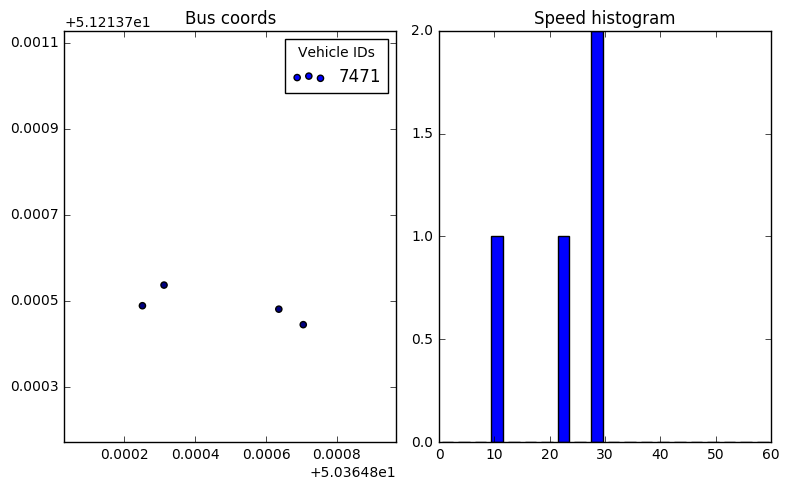

218 [0 0 0 0 3 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 73 lon_idx 1117
Cell line ID 218
[0 0 0 0 3 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 36
Num line points 7


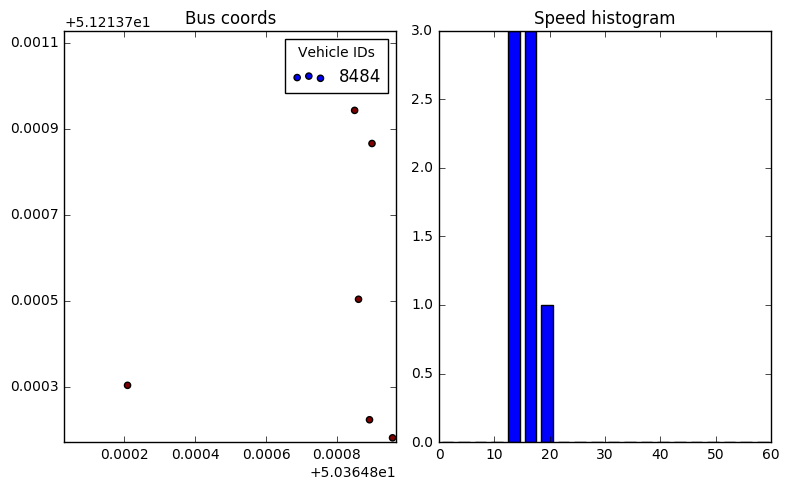

222 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0]
lat_idx 73 lon_idx 1117
Cell line ID 222
[0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0]
Is stop: [False]
Num cell points 36
Num line points 3


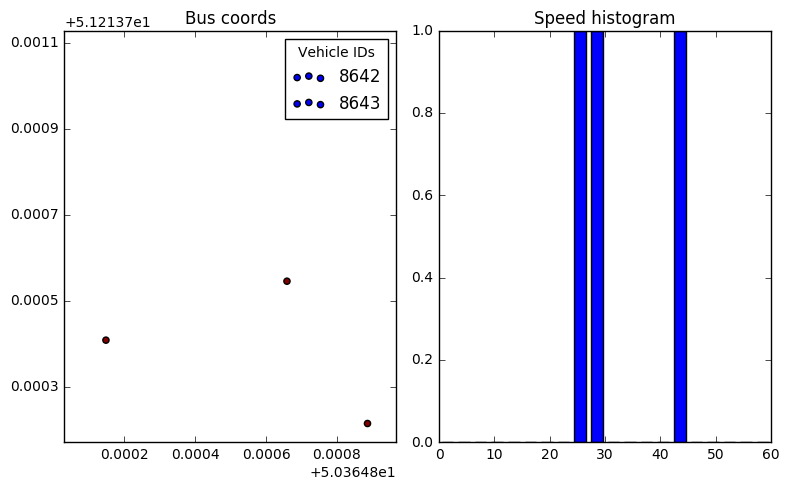

110 [0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 73 lon_idx 1118
Cell line ID 110
[0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 10
Num line points 3


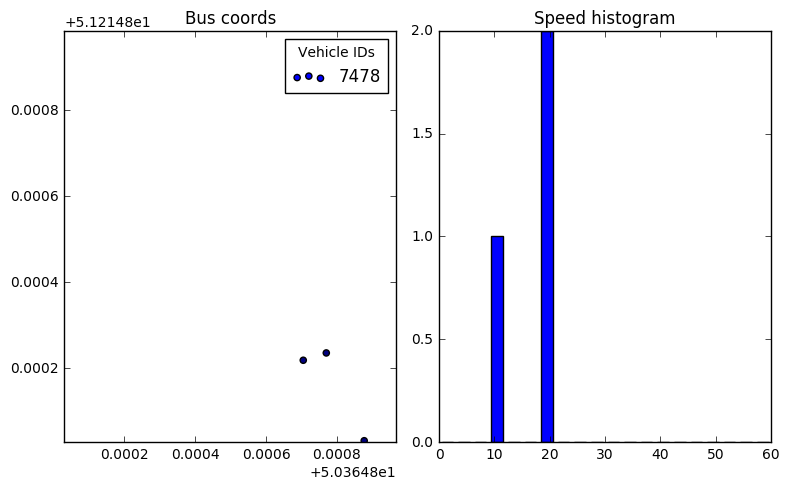

lat_idx 73 lon_idx 1118
Cell line ID 115
Num cell points 10
Num line points 1


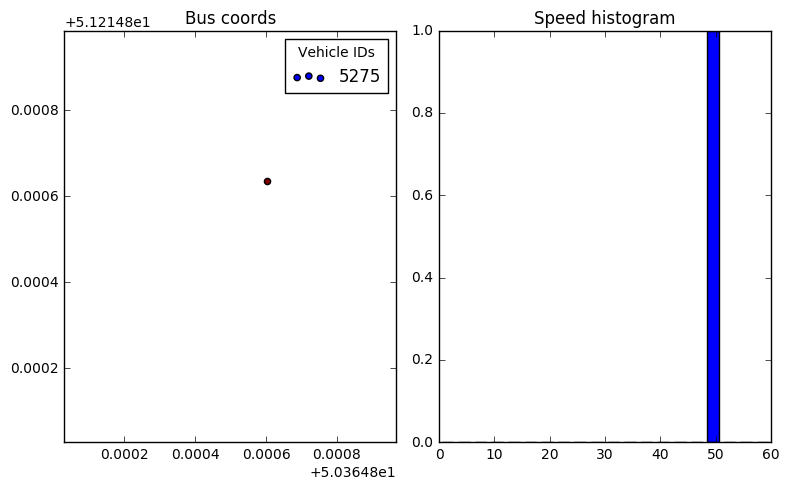

173 [0 0 0 0 2 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 73 lon_idx 1118
Cell line ID 173
[0 0 0 0 2 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 10
Num line points 4


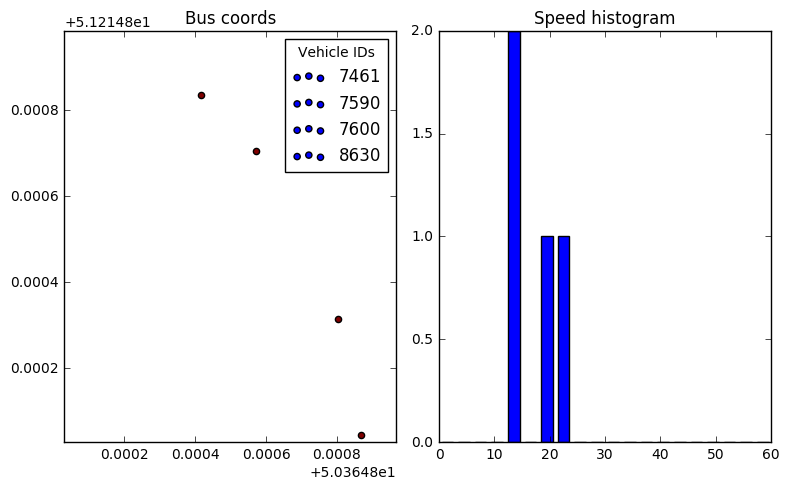

218 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
lat_idx 73 lon_idx 1118
Cell line ID 218
[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 10
Num line points 2


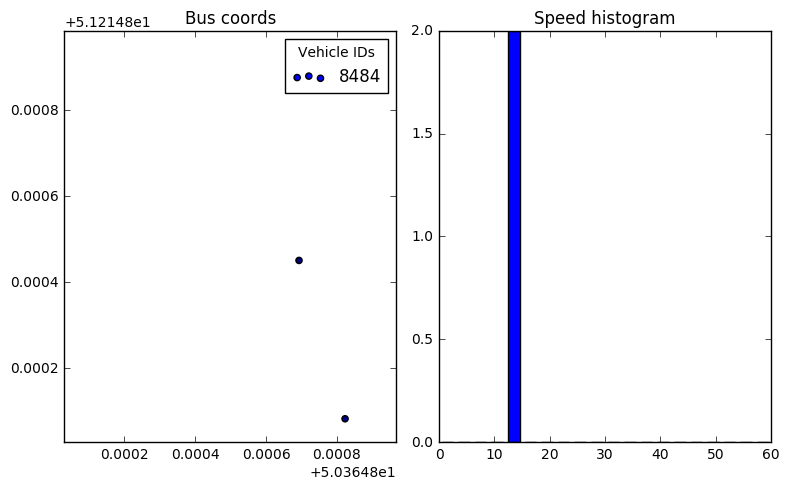

110 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
lat_idx 73 lon_idx 1119
Cell line ID 110
[0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
Is stop: [False]
Num cell points 10
Num line points 2


KeyboardInterrupt: 

In [51]:
# %%time
plt.close()
from timeit import default_timer
t = default_timer()

show_debug_data = True
save_csvs = False
answers = []
line_hist = None
line_bins = None
for lat_idx in range(num_cells_lat):
    if lat_idx % 1 == 0:
        print(lat_idx, default_timer() - t, 'num answers:', len(answers))
        t = default_timer()
        
    lat_start, lat_stop = lat_min + lat_idx * lat_step, lat_min + (lat_idx + 1) * lat_step
    df_lat_slice = df_with_speeds[(lat_start <= df_with_speeds['lat']) & (df_with_speeds['lat'] < lat_stop)]

    for lon_idx in range(num_cells_lon):
        lon_start, lon_stop = lon_min + lon_idx * lon_step, lon_min + (lon_idx + 1) * lon_step
        cell_data = df_lat_slice[(lon_start <= df_lat_slice['lon']) & (df_lat_slice['lon'] < lon_stop)]

        if cell_data.shape[0] < 10:
            continue
            
        for cell_line_id in cell_data['route_id'].unique():
            if show_debug_data:
                plt.close()
                fig = plt.figure(figsize=(8,5))
                ax1 = fig.add_subplot(121)
                plt.title('Bus coords')
                axes = plt.gca()
                axes.set_xlim([lat_start, lat_stop])
                axes.set_ylim([lon_start, lon_stop])
                X_len_before = len(X)
                cmap = plt.get_cmap('jet', len(line_id_df['transport_id'].unique()))
            
            line_id_df = cell_data[cell_data['route_id'] == cell_line_id]
            num_unique_transports = len(line_id_df['transport_id'].unique())
            
            line_hist = None
            line_bins = None
            for journey_idx, cell_journey_id in enumerate(line_id_df['transport_id'].unique()):
                journey_df = line_id_df[line_id_df['transport_id'] == cell_journey_id]

                if save_csvs:
                    save_dir = os.path.join('journey', str(lat_idx), str(lon_idx), cell_line_id)
                    os.makedirs(save_dir, exist_ok=True)
                    journey_df.to_csv(os.path.join(save_dir, cell_journey_id + '.csv'))

                features, bins = np.histogram(journey_df['Speed'], bins=20, range=(0, 60))
                if line_hist is None:
                    line_hist = features
                    line_bins = bins
                else:
                    line_hist += features
                
                if show_debug_data:
                    ax1.scatter(journey_df['lat'], journey_df['lon'], marker='o', c=[journey_idx] * journey_df.shape[0], label=cell_journey_id, cmap=cmap, vmin=0, vmax=num_unique_transports)
                    
            if line_hist is not None:
                if np.sum(line_hist) > 1:
                    print(cell_line_id, line_hist)
                    cell_features = line_hist / np.sum(line_hist)
                    pred = clf.predict(cell_features[np.newaxis])
                    if pred:
                        answers.append((lat_start + lat_step / 2, lon_start + lon_step / 2))


            if show_debug_data and line_hist is not None:
                print('lat_idx', lat_idx, 'lon_idx', lon_idx)
                print('Cell line ID', cell_line_id)
                if np.sum(line_hist) > 1:
                    print(line_hist)
                    print('Is stop:', pred)
                print('Num cell points', cell_data.shape[0])
                print('Num line points', line_id_df.shape[0])
                plt.legend(title="Vehicle IDs")
                width = 0.7 * (line_bins[1] - line_bins[0])
                center = (line_bins[:-1] + line_bins[1:]) / 2
                plt.subplot(122)
                plt.title('Speed histogram')
                plt.bar(center, line_hist, align='center', width=width)
                plt.tight_layout()
                plt.show()
            
                    
print('num samples:', len(X))
# print(X)
# print(y)

In [86]:
with open('ans.txt', 'w') as ans:
    ans.write(str(len(set(answers))) + '\n')
    for lat, lon in set(answers):
        ans.write(str(lat) + ' ' + str(lon) + '\n')

In [65]:
import random
random_answers = []
for lat_idx in range(num_cells_lat):
    lat_start, lat_stop = lat_min + lat_idx * lat_step, lat_min + (lat_idx + 1) * lat_step
    for lon_idx in range(num_cells_lon):
        lon_start, lon_stop = lon_min + lon_idx * lon_step, lon_min + (lon_idx + 1) * lon_step
        if random.random() > 0.999:
            random_answers.append((lat_start + lat_step / 2, lon_start + lon_step / 2))

In [67]:
num_cells_lat * num_cells_lon

1600000

In [66]:
len(random_answers)

1592